In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from joblib import dump, load
from joblib import Parallel, delayed  
from tldextract import extract
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
from scipy.stats import mannwhitneyu
def Mann_Whitney_U_test(srs1:pd.Series, srs2:pd.Series):
    
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='less')
    if p_value < 0.05:
        print(f"U: {u_statistic}, P: {p_value}", end=', ')
        print('The former is significantly smaller overall than the latter.')
        return
    
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='greater')
    if p_value < 0.05:
        print(f"U: {u_statistic}, P: {p_value}", end=', ')
        print('The former is significantly higher overall than the latter.')
        return
    
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='two-sided')
    print(f"U: {u_statistic}, P: {p_value}", end=', ')
    if p_value < 0.05:
        print('The former is significantly smaller overall than the latter.')
    else:
        print('The former is no significantly smaller overall than the latter.')


from scipy.stats import ttest_ind
def t_test(srs1:pd.Series, srs2:pd.Series):
    '''T test'''
    t_statistic, p_value = ttest_ind(srs1, srs2)
    print(f"T: {t_statistic}, P: {p_value}", end=', ')
    if p_value < 0.05:
        if t_statistic > 0:
            print('The former is significantly smaller overall than the latter.')
        else:
            print('The former is significantly higher overall than the latter.')
    else:
        print('The former is no significantly smaller overall than the latter.')


# 1. Twitter Platform

## QAnon

### 1. pessimism score caculate

In [2]:
name_suffix= "[v2][debunking=keywords][lang=en][topic=QAnon][platform=Twitter]"
user_texts_QAnon = pd.read_csv(f"/mnt/data/wenlu/rest-redditdata[24.7.19]/Twitter_reply/QAnon/user_texts{name_suffix}.csv")
user_texts_QAnon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9524 entries, 0 to 9523
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   in_reply_to_username     9524 non-null   object 
 1   text                     9524 non-null   object 
 2   text_simply_cleaned      9524 non-null   object 
 3   perspective_api_results  9486 non-null   object 
 4   toxicity                 9486 non-null   float64
 5   neg                      9522 non-null   float64
 6   neu                      9522 non-null   float64
 7   pos                      9522 non-null   float64
 8   compound                 9522 non-null   float64
 9   anger                    9524 non-null   float64
 10  anticipation             9524 non-null   float64
 11  disgust                  9524 non-null   float64
 12  fear                     9524 non-null   float64
 13  joy                      9524 non-null   float64
 14  love                    

In [ ]:

from transformers import pipeline
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pipe = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-emotion-multilabel-latest",
    return_all_scores=True,
    truncation=True,
    device=0 if torch.cuda.is_available() else -1  
)


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/home/wenlu/anaconda3/envs/angent/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
MAX_LENGTH = 512

def truncate_text(text, max_length=MAX_LENGTH):
    return text[:max_length]

def get_sentiment(text):
    # cut the Text
    truncated_text = truncate_text(text)
    result = pipe(truncated_text)
    # Get all labels ans scores
    sentiment_scores = {item['label']: item['score'] for item in result[0]}
    
    return sentiment_scores

In [ ]:
from tqdm import tqdm

user_texts_QAnon.dropna(subset= 'text', inplace= True)
tqdm.pandas()
user_texts_QAnon = user_texts_QAnon.join(
    user_texts_QAnon['text'].progress_apply(lambda x: pd.Series(get_sentiment(x)))
)

  0%|          | 0/9524 [00:00<?, ?it/s]

100%|██████████| 9524/9524 [01:25<00:00, 111.60it/s]


In [10]:
user_texts_QAnon.info()
user_texts_QAnon.to_csv(f"/mnt/data/wenlu/rest-redditdata[24.7.19]/Twitter_reply/QAnon/user_texts{name_suffix}.csv", index = False)

<class 'pandas.core.frame.DataFrame'>
Index: 9524 entries, 0 to 9525
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   in_reply_to_username     9524 non-null   object 
 1   text                     9524 non-null   object 
 2   text_simply_cleaned      9524 non-null   object 
 3   perspective_api_results  9486 non-null   object 
 4   toxicity                 9486 non-null   float64
 5   neg                      9522 non-null   float64
 6   neu                      9522 non-null   float64
 7   pos                      9522 non-null   float64
 8   compound                 9522 non-null   float64
 9   anger                    9524 non-null   float64
 10  anticipation             9524 non-null   float64
 11  disgust                  9524 non-null   float64
 12  fear                     9524 non-null   float64
 13  joy                      9524 non-null   float64
 14  love                     9524

### 2.Reply party

In [3]:
df_QAnon_party = pd.read_csv("QAnon/RPnetwork_Twitter-QAnon(lang=En)(moduralarity=3).csv")
df_QAnon_party.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23004 entries, 0 to 23003
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                23003 non-null  object
 1   Label             23003 non-null  object
 2   modularity_class  23004 non-null  int64 
 3   indegree          23004 non-null  int64 
 4   outdegree         23004 non-null  int64 
 5   degree            23004 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.1+ MB


In [ ]:
party1 = df_QAnon_party[(df_QAnon_party['modularity_class'] == 2)]
party1 # 2 class:Democrats

,Id,Label,modularity_class,indegree,outdegree,degree
2,thereal_truther,thereal_truther,2,3,2,5
4,mariedangelo22,mariedangelo22,2,0,1,1
5,NaN,NaN,2,5297,0,5297
14,KD2NFC,KD2NFC,2,0,1,1
21,stephenslayter,stephenslayter,2,0,1,1
...,...,...,...,...,...,...
22996,Pilot9,Pilot9,2,0,1,1
22997,crazy_dennis,crazy_dennis,2,0,1,1
22998,JOutwater,JOutwater,2,0,1,1
23001,DOsiedacz,DOsiedacz,2,0,1,1


In [21]:
sorted_df = party1.sort_values(by='degree', ascending=False)
sorted_df

,Id,Label,modularity_class,indegree,outdegree,degree
5,NaN,NaN,2,5297,0,5297
15527,Jordan_Sather_,Jordan_Sather_,2,13,0,13
17789,jeffrey_feff,jeffrey_feff,2,1,7,8
11538,BeTrueVoteBlue1,BeTrueVoteBlue1,2,4,3,7
11389,Loggerhead_,Loggerhead_,2,3,4,7
...,...,...,...,...,...,...
11967,spatialintell1,spatialintell1,2,0,1,1
11966,Jyve,Jyve,2,0,1,1
11964,FunkyCldMedina,FunkyCldMedina,2,0,1,1
11950,kasie,kasie,2,1,0,1


In [ ]:
party2 = df_QAnon_party[(df_QAnon_party['modularity_class'] == 1299)]
party2 # 1299 class:Republican

,Id,Label,modularity_class,indegree,outdegree,degree
33,SchmittNYC,SchmittNYC,1299,3,0,3
53,TooShortinAZ1,TooShortinAZ1,1299,0,1,1
54,POTUS,POTUS,1299,5,0,5
66,mwilson75,mwilson75,1299,0,1,1
67,BombshellDAILY,BombshellDAILY,1299,4,1,5
...,...,...,...,...,...,...
22844,LoriRosenberg19,LoriRosenberg19,1299,0,1,1
22875,_BackToEden_,_BackToEden_,1299,1,0,1
22920,JPBauer7,JPBauer7,1299,0,1,1
22936,ErnestoBorunda2,ErnestoBorunda2,1299,0,1,1


In [22]:
sorted_df = party2.sort_values(by='degree', ascending=False)
sorted_df

,Id,Label,modularity_class,indegree,outdegree,degree
7379,realDonaldTrump,realDonaldTrump,1299,439,0,439
822,conservatismDNA,conservatismDNA,1299,2,81,83
585,DonaldJTrumpJr,DonaldJTrumpJr,1299,55,0,55
322,ProjectLincoln,ProjectLincoln,1299,45,0,45
281,FoxNews,FoxNews,1299,39,0,39
...,...,...,...,...,...,...
22461,troj21,troj21,1299,0,1,1
22462,JJNightwalker,JJNightwalker,1299,0,1,1
22486,CarltonPabalan,CarltonPabalan,1299,0,1,1
22495,MachiavelliElmo,MachiavelliElmo,1299,0,1,1


In [ ]:
party3 = df_QAnon_party[(df_QAnon_party['modularity_class'] == 916)]
party3 # 916:republican

,Id,Label,modularity_class,indegree,outdegree,degree
6,DebraDee57,DebraDee57,916,0,1,1
7,SpeakerMcCarthy,SpeakerMcCarthy,916,25,0,25
8,DearGoodPeople,DearGoodPeople,916,0,12,12
9,mtgreenee,mtgreenee,916,224,0,224
10,RSBNetwork,RSBNetwork,916,3,0,3
...,...,...,...,...,...,...
22941,kathy_daehn,kathy_daehn,916,1,0,1
22942,Natasha57681056,Natasha57681056,916,1,0,1
22943,Hotel3_,Hotel3_,916,1,0,1
22944,SharaiyaN,SharaiyaN,916,1,0,1


In [23]:
sorted_df = party3.sort_values(by='degree', ascending=False)
sorted_df

,Id,Label,modularity_class,indegree,outdegree,degree
9,mtgreenee,mtgreenee,916,224,0,224
3359,actnowforward,actnowforward,916,1,209,210
79,laurenboebert,laurenboebert,916,70,0,70
313,Jim_Jordan,Jim_Jordan,916,48,0,48
101,RepMTG,RepMTG,916,42,0,42
...,...,...,...,...,...,...
20415,Fangrala1,Fangrala1,916,0,1,1
1065,TimmyTwoShirts,TimmyTwoShirts,916,1,0,1
1055,MattMontoya22,MattMontoya22,916,0,1,1
1042,ChefFrenchy,ChefFrenchy,916,0,1,1


In [ ]:
party4 = df_QAnon_party[(df_QAnon_party['modularity_class'] == 1537)]
party4 # 1537:democrats

,Id,Label,modularity_class,indegree,outdegree,degree
32,arizman2,arizman2,1537,0,27,27
37,EdBayne1,EdBayne1,1537,0,1,1
38,BillKristol,BillKristol,1537,13,0,13
40,Acyn,Acyn,1537,11,0,11
123,kimmeruwp,kimmeruwp,1537,1,3,4
...,...,...,...,...,...,...
22860,Domenic659,Domenic659,1537,0,1,1
22882,moomyungnim,moomyungnim,1537,0,1,1
22898,driftinginME,driftinginME,1537,0,1,1
22979,dustymair,dustymair,1537,0,1,1


In [24]:
sorted_df = party4.sort_values(by='degree', ascending=False)
sorted_df

,Id,Label,modularity_class,indegree,outdegree,degree
3027,Ernestobarr70,Ernestobarr70,1537,0,45,45
150,jaketapper,jaketapper,1537,35,0,35
494,MeidasTouch,MeidasTouch,1537,29,1,30
19174,Gerald_Weaver_,Gerald_Weaver_,1537,0,28,28
327,patriottakes,patriottakes,1537,26,1,27
...,...,...,...,...,...,...
22013,Silverm99819744,Silverm99819744,1537,1,0,1
22090,wallisweaver,wallisweaver,1537,1,0,1
22093,whatithink59,whatithink59,1537,0,1,1
22378,Tweetadeetlela1,Tweetadeetlela1,1537,0,1,1


In [ ]:
party5 = df_QAnon_party[(df_QAnon_party['modularity_class'] == 1964)]
party5 = party5.sort_values(by='degree', ascending=False) # 1964:Democrats
party5

,Id,Label,modularity_class,indegree,outdegree,degree,party
12782,Doogsfx,Doogsfx,1964,0,71,71,Unknown
261,Acosta,Acosta,1964,57,0,57,Unknown
393,PokerPolitics,PokerPolitics,1964,33,12,45,Unknown
1580,oneunderscore__,oneunderscore__,1964,40,1,41,Unknown
2171,travis_view,travis_view,1964,27,7,34,Unknown
...,...,...,...,...,...,...,...
2639,TheTroutmanShow,TheTroutmanShow,1964,0,1,1,Unknown
11032,townsend01_mr,townsend01_mr,1964,1,0,1,Unknown
10944,Dave4Trees,Dave4Trees,1964,1,0,1,Unknown
10896,adamdbld,adamdbld,1964,1,0,1,Unknown


In [ ]:
party6 = df_QAnon_party[(df_QAnon_party['modularity_class'] == 3810)]
party6 = party6.sort_values(by='degree', ascending=False) # 3810:Republican
party6

,Id,Label,modularity_class,indegree,outdegree,degree,party
297,CNN,CNN,3810,102,0,102,Unknown
13164,EyeCannotMeme,EyeCannotMeme,3810,0,56,56,Unknown
142,NBCNews,NBCNews,3810,48,1,49,Unknown
8272,nancylevine,nancylevine,3810,3,24,27,Unknown
2282,yashar,yashar,3810,24,0,24,Unknown
...,...,...,...,...,...,...,...
641,JordanBoak1,JordanBoak1,3810,0,1,1,Unknown
789,swin24,swin24,3810,1,0,1,Unknown
21758,HARLAN_M00CHIE,HARLAN_M00CHIE,3810,1,0,1,Unknown
21870,LowBudgetGenius,LowBudgetGenius,3810,1,0,1,Unknown


In [ ]:
party7 = df_QAnon_party[(df_QAnon_party['modularity_class'] == 1527)]
party7 = party7.sort_values(by='degree', ascending=False) # 1527:Democrats
party7

,Id,Label,modularity_class,indegree,outdegree,degree,party
291,thehill,thehill,1527,70,0,70,Unknown
364,washingtonpost,washingtonpost,1527,42,0,42,Unknown
903,IhoPwaitress74,IhoPwaitress74,1527,1,26,27,Unknown
12020,Silent_Courage,Silent_Courage,1527,0,26,26,Unknown
596,nytimes,nytimes,1527,23,0,23,Unknown
...,...,...,...,...,...,...,...
1145,68Rooster,68Rooster,1527,0,1,1,Unknown
21585,boulderfrog,boulderfrog,1527,0,1,1,Unknown
21736,SNoneida24,SNoneida24,1527,0,1,1,Unknown
21828,0_Y_G_Holman,0_Y_G_Holman,1527,1,0,1,Unknown


In [ ]:
party = df_QAnon_party[(df_QAnon_party['modularity_class'] == 2868)]
party = party.sort_values(by='degree', ascending=False) # 2868:Democrats
party

,Id,Label,modularity_class,indegree,outdegree,degree,party
7083,chadnoonan2,chadnoonan2,2868,0,81,81,Unknown
353,MSNBC,MSNBC,2868,56,0,56,Unknown
1052,QanonAnonymous,QanonAnonymous,2868,50,0,50,Unknown
397,rothschildmd,rothschildmd,2868,30,0,30,Unknown
3520,Shayan86,Shayan86,2868,19,2,21,Unknown
...,...,...,...,...,...,...,...
18318,ghostini1,ghostini1,2868,0,1,1,Unknown
17985,BUBAndrewBUB,BUBAndrewBUB,2868,0,1,1,Unknown
17894,ivannyssen,ivannyssen,2868,1,0,1,Unknown
17893,VeriteAbsolu,VeriteAbsolu,2868,1,0,1,Unknown


In [ ]:
# label party
conditions = [
    df_QAnon_party['modularity_class'].isin([2, 1537, 1964,1527]),   
    df_QAnon_party['modularity_class'].isin([1299, 916, 3810]) 
]
choices = ['Democrats', 'Republicans']

df_QAnon_party['party'] = np.select(conditions, choices, default='Unknown')

In [5]:
df_QAnon_party_notna = df_QAnon_party[df_QAnon_party['party'] != 'Unknown']
party_dict = df_QAnon_party_notna.set_index('Id')['party'].to_dict()

### Statistical analysis

In [6]:
user_texts_QAnon['party'] = user_texts_QAnon['in_reply_to_username'].map(party_dict)
user_texts_QAnon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9524 entries, 0 to 9523
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   in_reply_to_username     9524 non-null   object 
 1   text                     9524 non-null   object 
 2   text_simply_cleaned      9524 non-null   object 
 3   perspective_api_results  9486 non-null   object 
 4   toxicity                 9486 non-null   float64
 5   neg                      9522 non-null   float64
 6   neu                      9522 non-null   float64
 7   pos                      9522 non-null   float64
 8   compound                 9522 non-null   float64
 9   anger                    9524 non-null   float64
 10  anticipation             9524 non-null   float64
 11  disgust                  9524 non-null   float64
 12  fear                     9524 non-null   float64
 13  joy                      9524 non-null   float64
 14  love                    

In [7]:
democrats_data = user_texts_QAnon[user_texts_QAnon['party'] == 'Democrats']
republicans_data = user_texts_QAnon[user_texts_QAnon['party'] == 'Republicans']

In [ ]:
republicans_data.dropna(subset='toxicity', inplace=True)
democrats_data.dropna(subset='toxicity', inplace=True)
# Mann-Whitney U-test
print(f"Comparing bipartisan received toxicity:")
Mann_Whitney_U_test(democrats_data['toxicity'].to_list(), republicans_data['toxicity'].to_list())

比较两党的收到毒性:
U统计量: 826025.0, P值: 7.778223737344575e-08, 前者整体显著比后者小。


In [ ]:
# temporery 
republicans_data.dropna(subset='toxicity', inplace=True)
democrats_data.dropna(subset='toxicity', inplace=True)
# Mann-Whitney U-test Pessimism with greater
print(f"Comparing bipartisan received toxicity:")
u_statistic, p_value = mannwhitneyu(democrats_data['toxicity'].to_list(), republicans_data['toxicity'].to_list(), alternative='greater')
print(f"U统计量: {u_statistic}, P值: {p_value}", end=', ')

比较两党的收到毒性情绪:
U统计量: 826025.0, P值: 0.999999922237877, 

In [ ]:
republicans_data.dropna(subset='pessimism', inplace=True)
democrats_data.dropna(subset='pessimism', inplace=True)
# Mann-Whitney U
print(f"Comparing bipartisan received toxicity:")
Mann_Whitney_U_test(democrats_data['pessimism'].to_list(), republicans_data['pessimism'].to_list())

比较两党的收到悲观情绪:
U统计量: 862412.5, P值: 0.000223283707526608, 前者整体显著比后者小。


In [ ]:
# temporery 
republicans_data.dropna(subset='pessimism', inplace=True)
democrats_data.dropna(subset='pessimism', inplace=True)
# pessimism:greater
print(f"Comparing bipartisan received toxicity:")
u_statistic, p_value = mannwhitneyu(democrats_data['pessimism'].to_list(), republicans_data['pessimism'].to_list(), alternative='greater')
print(f"U统计量: {u_statistic}, P值: {p_value}", end=', ')

比较两党的收到悲观情绪:
U统计量: 872424.5, P值: 0.9997943970200739, 

In [11]:
rt_QA = pd.read_csv(f"/mnt/data/wenlu/rest-redditdata[24.7.19]/Twitter_reply/QAnon/reply{name_suffix}.csv")

In [12]:
toxic_dict = user_texts_QAnon.set_index('in_reply_to_username')['toxicity'].to_dict()
comp_dict = user_texts_QAnon.set_index('in_reply_to_username')['compound'].to_dict()
pess_dict = user_texts_QAnon.set_index('in_reply_to_username')['pessimism'].to_dict()

In [13]:
rt_QA['toxicity'] = rt_QA['in_reply_to_username'].map(toxic_dict)
rt_QA['pessimism'] = rt_QA['in_reply_to_username'].map(pess_dict)
rt_QA['compound'] = rt_QA['in_reply_to_username'].map(comp_dict)
rt_QA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22964 entries, 0 to 22963
Data columns (total 86 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     22964 non-null  int64  
 1   conversation_id                        22964 non-null  int64  
 2   referenced_tweets.replied_to.id        22964 non-null  float64
 3   referenced_tweets.retweeted.id         0 non-null      float64
 4   referenced_tweets.quoted.id            412 non-null    float64
 5   author_id                              22964 non-null  int64  
 6   in_reply_to_user_id                    22964 non-null  float64
 7   in_reply_to_username                   16187 non-null  object 
 8   retweeted_user_id                      0 non-null      float64
 9   retweeted_username                     0 non-null      float64
 10  quoted_user_id                         412 non-null    float64
 11  qu

In [ ]:
rt_QA['party'] = rt_QA['in_reply_to_username'].map(party_dict)
df = rt_QA.dropna(subset = ['party'])
def g(df):
    #  # Count the number of times each 'in_reply_to_username' has been replied to
    df_grouped = df.groupby('in_reply_to_username')['author.username'].count().reset_index()
    df_grouped.columns = ['in_reply_to_username', 'count']

    # Maximum/median for columns 'toxicity', 'compound', 'pessimism' grouped by 'in_reply_to_username'
    df_max_values = df.groupby('in_reply_to_username')[['toxicity', 'compound', 'pessimism']].median()


    df_merged = pd.merge(df_grouped, df_max_values, on='in_reply_to_username')

    return df_merged

# call for the function
result = g(df.copy())
print(result)


     in_reply_to_username  count  toxicity  compound  pessimism
0              04pistons1      1  0.050821    0.0000   0.057462
1            0_Y_G_Holman      1  0.053542   -0.3400   0.077280
2          1000_FacedHero      1  0.278628   -0.2500   0.060120
3               100Dianne      1  0.246033   -0.8934   0.045974
4              100_shades      1  0.241222   -0.6249   0.076339
...                   ...    ...       ...       ...        ...
2830            zimmy1998      1  0.304898   -0.9111   0.053039
2831           zinemaniac      1  0.687436   -0.8658   0.038829
2832           zleegaspar      1  0.137353   -0.8860   0.060038
2833           zorayda235      1  0.330229   -0.6966   0.054668
2834             zydecoop      3  0.165919       NaN   0.057464

[2835 rows x 5 columns]


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14747 entries, 1 to 22963
Data columns (total 87 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     14747 non-null  int64  
 1   conversation_id                        14747 non-null  int64  
 2   referenced_tweets.replied_to.id        14747 non-null  float64
 3   referenced_tweets.retweeted.id         0 non-null      float64
 4   referenced_tweets.quoted.id            302 non-null    float64
 5   author_id                              14747 non-null  int64  
 6   in_reply_to_user_id                    14747 non-null  float64
 7   in_reply_to_username                   7970 non-null   object 
 8   retweeted_user_id                      0 non-null      float64
 9   retweeted_username                     0 non-null      float64
 10  quoted_user_id                         302 non-null    float64
 11  quoted_

In [16]:
party_dict = rt_QA.set_index('in_reply_to_username')['party'].to_dict()
result['party'] = result['in_reply_to_username'].map(party_dict)
result

,in_reply_to_username,count,toxicity,compound,pessimism,party
0,04pistons1,1,0.050821,0.0000,0.057462,Democrats
1,0_Y_G_Holman,1,0.053542,-0.3400,0.077280,Democrats
2,1000_FacedHero,1,0.278628,-0.2500,0.060120,Republicans
3,100Dianne,1,0.246033,-0.8934,0.045974,Democrats
4,100_shades,1,0.241222,-0.6249,0.076339,Republicans
...,...,...,...,...,...,...
2830,zimmy1998,1,0.304898,-0.9111,0.053039,Republicans
2831,zinemaniac,1,0.687436,-0.8658,0.038829,Democrats
2832,zleegaspar,1,0.137353,-0.8860,0.060038,Democrats
2833,zorayda235,1,0.330229,-0.6966,0.054668,Democrats


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import statsmodels.api as sm

subdivide_data = result

# Obtain separate data for Democrats and Republicans.
democrats_data = subdivide_data[subdivide_data['party'] == 'Democrats']
republicans_data = subdivide_data[subdivide_data['party'] == 'Republicans']

In [18]:
print(len(democrats_data))
print(len(republicans_data))

1755
1080


In [ ]:

democrats_max_df = democrats_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()
republicans_max_df = republicans_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()

In [ ]:

republicans_max_df['party'] = 'republicans'
democrats_max_df['party'] = 'democrats'

In [21]:
print(len(democrats_max_df))
print(len(republicans_max_df))

36
39


In [22]:
df_QAnon = pd.concat([republicans_max_df, democrats_max_df])
df_QAnon.reset_index(drop=True, inplace=True)
df_QAnon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   count      75 non-null     int64  
 1   pessimism  75 non-null     float64
 2   toxicity   72 non-null     float64
 3   party      75 non-null     object 
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ KB


## POTUS2016

### 1. pessimism score caculate

In [7]:
name_suffix= "[v5][debunking=keywords][lang=en][topic=POTUS2016][platform=Twitter]"
user_texts_2016 = pd.read_csv(f"POTUS2016/user_texts{name_suffix}.csv")
user_texts_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29490 entries, 0 to 29489
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   in_reply_to_username  29490 non-null  object 
 1   text                  29490 non-null  object 
 2   text_simply_cleaned   29490 non-null  object 
 3   toxicity              29368 non-null  float64
 4   anger                 29490 non-null  float64
 5   anticipation          29490 non-null  float64
 6   disgust               29490 non-null  float64
 7   fear                  29490 non-null  float64
 8   joy                   29490 non-null  float64
 9   love                  29490 non-null  float64
 10  optimism              29490 non-null  float64
 11  pessimism             29490 non-null  float64
 12  sadness               29490 non-null  float64
 13  surprise              29490 non-null  float64
 14  trust                 29490 non-null  float64
 15  neg                

In [ ]:

from transformers import pipeline
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pipe = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-emotion-multilabel-latest",
    return_all_scores=True,
    truncation=True,
    device=0 if torch.cuda.is_available() else -1  
)


In [ ]:
MAX_LENGTH = 512

def truncate_text(text, max_length=MAX_LENGTH):
    return text[:max_length]

def get_sentiment(text):
    
    truncated_text = truncate_text(text)
    result = pipe(truncated_text)
    
    sentiment_scores = {item['label']: item['score'] for item in result[0]}
    
    return sentiment_scores

In [ ]:
from tqdm import tqdm

user_texts_2016.dropna(subset= 'text', inplace= True)
tqdm.pandas()
user_texts_2016 = user_texts_2016.join(
    user_texts_2016['text'].progress_apply(lambda x: pd.Series(get_sentiment(x)))
)

  0%|          | 0/29490 [00:00<?, ?it/s]

100%|██████████| 29490/29490 [04:22<00:00, 112.48it/s]


In [46]:
user_texts_2016.info()
user_texts_2016.to_csv(f"POTUS2016/user_texts{name_suffix}.csv", index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29490 entries, 0 to 29489
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   in_reply_to_username  29490 non-null  object 
 1   text                  29490 non-null  object 
 2   text_simply_cleaned   29490 non-null  object 
 3   toxicity              29368 non-null  float64
 4   anger                 29490 non-null  float64
 5   anticipation          29490 non-null  float64
 6   disgust               29490 non-null  float64
 7   fear                  29490 non-null  float64
 8   joy                   29490 non-null  float64
 9   love                  29490 non-null  float64
 10  optimism              29490 non-null  float64
 11  pessimism             29490 non-null  float64
 12  sadness               29490 non-null  float64
 13  surprise              29490 non-null  float64
 14  trust                 29490 non-null  float64
dtypes: float64(12), obj

### 2. Reply party

In [8]:
df_2016_party = pd.read_csv("POTUS2016/RPnetwork_Twitter-POTUS2016(lang=En)(moduralarity=3).csv")
df_2016_party.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130702 entries, 0 to 130701
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Id                130702 non-null  object
 1   Label             130702 non-null  object
 2   indegree          130702 non-null  int64 
 3   outdegree         130702 non-null  int64 
 4   degree            130702 non-null  int64 
 5   modularity_class  130702 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 6.0+ MB


In [ ]:
party1 = df_2016_party[(df_2016_party['modularity_class'] == 0)]
party1 = party1.sort_values(by='degree', ascending=False)
party1.head(25) # 0class:Republicans

,Id,Label,indegree,outdegree,degree,modularity_class
1,realDonaldTrump,realDonaldTrump,65183,0,65183,0
1295,POTUS45,POTUS45,203,0,203,0
20583,EricTrump,EricTrump,64,0,64,0
33,WhiteHouse45,WhiteHouse45,48,0,48,0
13295,VP45,VP45,44,0,44,0
19089,SnapmasterNFT,SnapmasterNFT,23,9,32,0
4682,jasoninthehouse,jasoninthehouse,21,0,21,0
56406,doctorcherokee,doctorcherokee,8,13,21,0
89986,mcw0530,mcw0530,14,6,20,0
57934,josephcourson,josephcourson,15,2,17,0


In [ ]:
party2 = df_2016_party[(df_2016_party['modularity_class'] == 6)]
party2 = party2.sort_values(by='degree', ascending=False)
party2.head(25) # 6 class:Democrats

,Id,Label,indegree,outdegree,degree,modularity_class
37,CNN,CNN,2874,0,2874,6
1105,FoxNews,FoxNews,2762,1,2763,6
90,thehill,thehill,1354,0,1354,6
22,politico,politico,1236,0,1236,6
14,nytimes,nytimes,1150,1,1151,6
1361,washingtonpost,washingtonpost,811,0,811,6
1328,CNNPolitics,CNNPolitics,794,0,794,6
204,jaketapper,jaketapper,685,0,685,6
1479,HillaryClinton,HillaryClinton,587,0,587,6
16240,KellyannePolls,KellyannePolls,580,0,580,6


In [ ]:
party3 = df_2016_party[(df_2016_party['modularity_class'] == 28)]
party3 = party3.sort_values(by='degree', ascending=False)
party3.head(25) # 28 class Democrats

,Id,Label,indegree,outdegree,degree,modularity_class
229,krassenstein,krassenstein,489,0,489,28
8350,bd13628,bd13628,410,2,412,28
971,Mike_P_Williams,Mike_P_Williams,275,6,281,28
2986,tonyposnanski,tonyposnanski,248,2,250,28
1935,williamlegate,williamlegate,195,3,198,28
1832,AJ,AJ,166,4,170,28
52,mskristinawong,mskristinawong,151,5,156,28
7552,bessbell,bessbell,143,2,145,28
49363,Holly_in_CA,Holly_in_CA,120,12,132,28
1505,AynRandPaulRyan,AynRandPaulRyan,123,5,128,28


In [ ]:
party4 = df_2016_party[(df_2016_party['modularity_class'] == 96)]
party4 = party4.sort_values(by='degree', ascending=False)
party4.head(25) # 96 class Democrats

,Id,Label,indegree,outdegree,degree,modularity_class
1332,20committee,20committee,58,0,58,96
2290,amanpour,amanpour,16,0,16,96
15252,BenSasse,BenSasse,13,0,13,96
23264,johnpavlovitz,johnpavlovitz,9,1,10,96
1873,KT_So_It_Goes,KT_So_It_Goes,6,1,7,96
21849,SmallAxe2016,SmallAxe2016,3,4,7,96
46147,mrsk23_mm,mrsk23_mm,0,7,7,96
46721,LPDonovan,LPDonovan,4,2,6,96
52439,TooTrue810,TooTrue810,3,3,6,96
15413,MRodrigoX,MRodrigoX,0,6,6,96


In [ ]:
party5 = df_2016_party[(df_2016_party['modularity_class'] == 2724)]
party5 = party5.sort_values(by='degree', ascending=False)
party5.head(25) # 5975 Democrats

,Id,Label,indegree,outdegree,degree,modularity_class
8709,Davidmetroland,Davidmetroland,1,10,11,2724
74121,SoniaKatiMota,SoniaKatiMota,6,4,10,2724
36183,Bonn1eGreer,Bonn1eGreer,5,1,6,2724
30747,kneadinghands,kneadinghands,1,5,6,2724
22245,sillygrandma99,sillygrandma99,2,3,5,2724
80248,medialens,medialens,4,0,4,2724
10746,AnnastasiaM67,AnnastasiaM67,0,4,4,2724
12111,Ellahbie,Ellahbie,3,0,3,2724
79652,LaynieR,LaynieR,3,0,3,2724
29498,DeepInTheHills,DeepInTheHills,0,3,3,2724


In [ ]:

conditions = [
    df_2016_party['modularity_class'].isin([6, 28, 96,10069]),   
    df_2016_party['modularity_class'].isin([0]) 
]
choices = ['Democrats', 'Republicans']


df_2016_party['party'] = np.select(conditions, choices, default='Unknown')

In [11]:
df_2016_party_notna = df_2016_party[df_2016_party['party'] != 'Unknown']
party_dict = df_2016_party_notna.set_index('Id')['party'].to_dict()

In [12]:
party = df_2016_party_notna.value_counts(subset='party')
party

party
Republicans    58169
Democrats      50095
Name: count, dtype: int64

### 3.M-W Utest 

In [13]:
user_texts_2016 = pd.read_csv(f"/mnt/data/wenlu/rest-redditdata[24.7.19]/Twitter_reply/POTUS2016/user_texts{name_suffix}.csv")
user_texts_2016['party'] = user_texts_2016['in_reply_to_username'].map(party_dict)
user_texts_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29490 entries, 0 to 29489
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   in_reply_to_username  29490 non-null  object 
 1   text                  29490 non-null  object 
 2   text_simply_cleaned   29490 non-null  object 
 3   toxicity              29368 non-null  float64
 4   anger                 29490 non-null  float64
 5   anticipation          29490 non-null  float64
 6   disgust               29490 non-null  float64
 7   fear                  29490 non-null  float64
 8   joy                   29490 non-null  float64
 9   love                  29490 non-null  float64
 10  optimism              29490 non-null  float64
 11  pessimism             29490 non-null  float64
 12  sadness               29490 non-null  float64
 13  surprise              29490 non-null  float64
 14  trust                 29490 non-null  float64
 15  neg                

In [14]:
democrats_data = user_texts_2016[user_texts_2016['party'] == 'Democrats']
republicans_data = user_texts_2016[user_texts_2016['party'] == 'Republicans']

In [ ]:
# for temporary
def Mann_Whitney_U_test(srs1:pd.Series, srs2:pd.Series):
    
    u_statistic, p_value = mannwhitneyu(srs1, srs2, alternative='less')
    if p_value < 0.05:
        print(f"U: {u_statistic}, P: {p_value}", end=', ')
        print('Democrats were replied with toxicity')
        return

In [ ]:
republicans_data.dropna(subset='toxicity', inplace=True)
democrats_data.dropna(subset='toxicity', inplace=True)
# 进行 Mann-Whitney U 检验 毒性用“less”
print(f"Comparing Bipartisan Received Toxicity.:")
u_statistic, p_value = mannwhitneyu(democrats_data['toxicity'].to_list(), republicans_data['toxicity'].to_list(), alternative='less')
print(f"U: {u_statistic}, P: {p_value}", end=', ')
    #print('前者整体显著比后者小。')

比较两党的收到毒性:
U统计量: 18304546.5, P值: 0.9999999996160834, 

In [ ]:
republicans_data.dropna(subset='pessimism', inplace=True)
democrats_data.dropna(subset='pessimism', inplace=True)
# 进行 Mann-Whitney U 检验
print(f"Comparing Bipartisan Received Toxicity.:")
Mann_Whitney_U_test(democrats_data['pessimism'].to_list(), republicans_data['pessimism'].to_list())

比较两党的收到悲观情绪最大值:
U统计量: 15862083.5, P值: 1.4226253230380862e-07, 前者整体显著比后者小。


In [ ]:
# temporery 
republicans_data.dropna(subset='pessimism', inplace=True)
democrats_data.dropna(subset='pessimism', inplace=True)
# pessimism:greater
print(f"Comparing Bipartisan Received Toxicity:")
u_statistic, p_value = mannwhitneyu(democrats_data['pessimism'].to_list(), republicans_data['pessimism'].to_list(), alternative='greater')
print(f"U: {u_statistic}, P: {p_value}", end=', ')

比较两党的收到悲观情绪:
U统计量: 15862083.5, P值: 0.9999998577409616, 

In [31]:
rt_2016 = pd.read_csv(f"POTUS2016/reply{name_suffix}.csv")

In [32]:
toxic_dict = user_texts_2016.set_index('in_reply_to_username')['toxicity'].to_dict()
comp_dict = user_texts_2016.set_index('in_reply_to_username')['compound'].to_dict()
pess_dict = user_texts_2016.set_index('in_reply_to_username')['pessimism'].to_dict()

In [33]:
rt_2016['toxicity'] = rt_2016['in_reply_to_username'].map(toxic_dict)
rt_2016['pessimism'] = rt_2016['in_reply_to_username'].map(pess_dict)
rt_2016['compound'] = rt_2016['in_reply_to_username'].map(comp_dict)
rt_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244493 entries, 0 to 244492
Data columns (total 86 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     244493 non-null  int64  
 1   conversation_id                        244493 non-null  int64  
 2   referenced_tweets.replied_to.id        244493 non-null  float64
 3   referenced_tweets.retweeted.id         0 non-null       float64
 4   referenced_tweets.quoted.id            614 non-null     float64
 5   author_id                              244493 non-null  int64  
 6   in_reply_to_user_id                    244493 non-null  float64
 7   in_reply_to_username                   202637 non-null  object 
 8   retweeted_user_id                      0 non-null       float64
 9   retweeted_username                     0 non-null       float64
 10  quoted_user_id                         614 non-null     

In [ ]:
rt_2016['party'] = rt_2016['in_reply_to_username'].map(party_dict)
df = rt_2016.dropna(subset = ['party'])
def g(df):
    # Count the number of times each 'in_reply_to_username' has been replied to
    df_grouped = df.groupby('in_reply_to_username')['author.username'].count().reset_index()
    df_grouped.columns = ['in_reply_to_username', 'count']

    # Count the number of times each 'in_reply_to_username' has been replied to
    df_max_values = df.groupby('in_reply_to_username')[['toxicity', 'compound', 'pessimism']].median()

    df_merged = pd.merge(df_grouped, df_max_values, on='in_reply_to_username')

    return df_merged

result = g(df.copy())
print(result)


      in_reply_to_username  count  toxicity  compound  pessimism
0             004magdalene      1  0.261044   -0.4767   0.053426
1              007Watchdog      1  0.268591   -0.0276   0.026128
2                01jacky01      1  0.198934   -0.6529   0.038340
3                  03lefty      1  0.058243    0.5473   0.043712
4                   0cotzi      1  0.028503    0.3724   0.028418
...                    ...    ...       ...       ...        ...
16642             zuludogm      1  0.142560   -0.5904   0.049033
16643              zusie57      1  0.659969   -0.3818   0.034793
16644            zwycieski      1  0.154903   -0.8720   0.058980
16645      zzzanthropology      1  0.459215   -0.9452   0.126921
16646      zzzzaaaacccchhh      8  0.457515   -0.9787   0.042726

[16647 rows x 5 columns]


In [35]:
#party_dict = rt_2016.set_index('in_reply_to_username')['party'].to_dict()
result['party'] = result['in_reply_to_username'].map(party_dict)
result

,in_reply_to_username,count,toxicity,compound,pessimism,party
0,004magdalene,1,0.261044,-0.4767,0.053426,Republicans
1,007Watchdog,1,0.268591,-0.0276,0.026128,Republicans
2,01jacky01,1,0.198934,-0.6529,0.038340,Democrats
3,03lefty,1,0.058243,0.5473,0.043712,Democrats
4,0cotzi,1,0.028503,0.3724,0.028418,Democrats
...,...,...,...,...,...,...
16642,zuludogm,1,0.142560,-0.5904,0.049033,Democrats
16643,zusie57,1,0.659969,-0.3818,0.034793,Democrats
16644,zwycieski,1,0.154903,-0.8720,0.058980,Democrats
16645,zzzanthropology,1,0.459215,-0.9452,0.126921,Democrats


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import statsmodels.api as sm

subdivide_data = result

democrats_data = subdivide_data[subdivide_data['party'] == 'Democrats']
republicans_data = subdivide_data[subdivide_data['party'] == 'Republicans']

In [37]:
print(len(democrats_data))
print(len(republicans_data))

14237
2410


In [ ]:
democrats_max_df = democrats_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()
republicans_max_df = republicans_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()

In [39]:
democrats_max_df

,count,pessimism,toxicity
0,1,0.053024,0.202889
1,2,0.050290,0.304648
2,3,0.048599,0.334217
3,4,0.046322,0.363540
4,5,0.046568,0.377512
...,...,...,...
170,1459,0.037698,NaN
171,1609,0.019815,NaN
172,1909,0.042693,NaN
173,3562,0.051090,NaN


In [ ]:
republicans_max_df['party'] = 'republicans'
democrats_max_df['party'] = 'democrats'

In [41]:
print(len(democrats_max_df))
print(len(republicans_max_df))

175
23


In [42]:
df_2016 = pd.concat([republicans_max_df, democrats_max_df])
df_2016.reset_index(drop=True, inplace=True)
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   count      198 non-null    int64  
 1   pessimism  198 non-null    float64
 2   toxicity   148 non-null    float64
 3   party      198 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 6.3+ KB


#### 3.1toxicity

In [43]:
df_2016['log_count'] = np.log(df_2016['count'])
republicans_max_df['log_count'] = np.log(republicans_max_df['count'])
democrats_max_df['log_count'] = np.log(democrats_max_df['count'])

#### 3.2 pessimism

In [ ]:
print(f"Comparing the maximum pessimism responded to by users of both parties:")
Mann_Whitney_U_test(democrats_max_df['pessimism'], republicans_max_df['pessimism'])

比较两党用户的被回复的悲观情绪最大值:
U统计量: 1332.0, P值: 0.995615461815168, 两组数据之间没有显著差异。


In [52]:
# Democrats 数据
x_dem = democrats_max_df['log_count']
y_dem = democrats_max_df['pessimism']
r_dem, r2_dem = compute_r_and_r2_nonlinear(x_dem, y_dem, model_func=np.polyval)

# Republicans 数据
x_rep = republicans_max_df['log_count']
y_rep = republicans_max_df['pessimism']
r_rep, r2_rep = compute_r_and_r2_nonlinear(x_rep, y_rep, model_func=np.polyval)

df_2016.dropna(inplace=True)
# 总数据
x = df_2016['log_count']
y = df_2016['pessimism']
r, r2 = compute_r_and_r2_nonlinear(x, y, model_func=np.polyval)

## POTUS2020

### 1. pessimism score caculate

In [11]:
user_texts_2020 = pd.read_csv(f"/mnt/data/wenlu/rest-redditdata[24.7.19]/Twitter_reply/POTUS2020/toxicity_of_replytext[topic=POTUS2020][platform=Twitter][lang=en][debunking=keywords]_2 (1).csv")
user_texts_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183006 entries, 0 to 183005
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   in_reply_to_username     183006 non-null  object 
 1   text                     183006 non-null  object 
 2   text_simply_cleaned      183006 non-null  object 
 3   perspective_api_results  183006 non-null  object 
 4   toxicity                 183006 non-null  float64
 5   anger                    183006 non-null  float64
 6   anticipation             183006 non-null  float64
 7   disgust                  183006 non-null  float64
 8   fear                     183006 non-null  float64
 9   joy                      183006 non-null  float64
 10  love                     183006 non-null  float64
 11  optimism                 183006 non-null  float64
 12  pessimism                183006 non-null  float64
 13  sadness                  183006 non-null  float64
 14  surp

In [ ]:
# loda the model
from transformers import pipeline
import torch
# set:GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pipe = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-emotion-multilabel-latest",
    return_all_scores=True,
    truncation=True,
    device=0 if torch.cuda.is_available() else -1  
)


/home/wenlu/anaconda3/envs/angent/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
MAX_LENGTH = 512

def truncate_text(text, max_length=MAX_LENGTH):
    return text[:max_length]

def get_sentiment(text):
    # cut text
    truncated_text = truncate_text(text)
    result = pipe(truncated_text)
    # get all labels and scores
    sentiment_scores = {item['label']: item['score'] for item in result[0]}
    
    return sentiment_scores

In [ ]:
from tqdm import tqdm
user_texts_2020.dropna(subset= 'text', inplace= True)
tqdm.pandas()
user_texts_2020 = user_texts_2020.join(
    user_texts_2020['text'].progress_apply(lambda x: pd.Series(get_sentiment(x)))
)

  0%|          | 0/183006 [00:00<?, ?it/s]

100%|██████████| 183006/183006 [24:11<00:00, 126.05it/s] 


In [ ]:
user_texts_2020.info()
user_texts_2020.to_csv("POTUS2020/toxicity_of_replytext[topic=POTUS2020][platform=Twitter][lang=en][debunking=keywords]_2 (1).csv", index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183006 entries, 0 to 183005
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   in_reply_to_username     183006 non-null  object 
 1   text                     183006 non-null  object 
 2   text_simply_cleaned      183006 non-null  object 
 3   perspective_api_results  183006 non-null  object 
 4   toxicity                 183006 non-null  float64
 5   anger                    183006 non-null  float64
 6   anticipation             183006 non-null  float64
 7   disgust                  183006 non-null  float64
 8   fear                     183006 non-null  float64
 9   joy                      183006 non-null  float64
 10  love                     183006 non-null  float64
 11  optimism                 183006 non-null  float64
 12  pessimism                183006 non-null  float64
 13  sadness                  183006 non-null  float64
 14  surp

### 2. Reply party

In [12]:
df_2020_party = pd.read_csv("POTUS2020/RPnetwork_Twitter- POTUS2020(lang=En)(moduralarity=2).csv")
df_2020_party.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590760 entries, 0 to 590759
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Id                590759 non-null  object
 1   Label             590759 non-null  object
 2   indegree          590760 non-null  int64 
 3   outdegree         590760 non-null  int64 
 4   degree            590760 non-null  int64 
 5   modularity_class  590760 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 27.0+ MB


In [ ]:
party1 = df_2020_party[(df_2020_party['modularity_class'] == 29825)]
party1 = party1.sort_values(by='degree', ascending=False)
party1.head(25) # 29825：Rep.

,Id,Label,indegree,outdegree,degree,modularity_class
6,NaN,NaN,125091,0,125091,29825
36593,the_resistor,the_resistor,681,7,688,29825
59668,wdunlap,wdunlap,487,13,500,29825
543,DawnsMission,DawnsMission,366,5,371,29825
56228,CHIZMAGA,CHIZMAGA,346,0,346,29825
7981,EvanAKilgore,EvanAKilgore,291,6,297,29825
61529,enes69,enes69,287,0,287,29825
57094,CodeMonkeyZ,CodeMonkeyZ,265,0,265,29825
72,Annakhait,Annakhait,198,5,203,29825
11357,fake_news_u_r,fake_news_u_r,188,2,190,29825


In [ ]:
party2 = df_2020_party[(df_2020_party['modularity_class'] == 25996)]
party2 = party2.sort_values(by='degree', ascending=False)
party2.head(25) # 25996：Rep

,Id,Label,indegree,outdegree,degree,modularity_class
50339,realDonaldTrump,realDonaldTrump,167662,0,167662,25996
6203,gatewaypundit,gatewaypundit,763,0,763,25996
13098,real_defender,real_defender,737,1,738,25996
37703,MatthewJshow,MatthewJshow,608,4,612,25996
7237,ChanelRion,ChanelRion,554,0,554,25996
1743,realLizUSA,realLizUSA,381,1,382,25996
11701,SenMastriano,SenMastriano,370,0,370,25996
7053,christina_bobb,christina_bobb,339,0,339,25996
988,FLOTUS45,FLOTUS45,296,0,296,25996
42548,KelemenCari,KelemenCari,260,1,261,25996


In [ ]:
party3 = df_2020_party[(df_2020_party['modularity_class'] == 3867)]
party3 = party3.sort_values(by='degree', ascending=False)
party3.head(25) # 3867：rep

,Id,Label,indegree,outdegree,degree,modularity_class
161,DonaldJTrumpJr,DonaldJTrumpJr,14897,0,14897,3867
740,EricTrump,EricTrump,7787,0,7787,3867
370,IvankaTrump,IvankaTrump,5740,0,5740,3867
234,kayleighmcenany,kayleighmcenany,4445,0,4445,3867
3228,TrumpWarRoom,TrumpWarRoom,3547,34,3581,3867
48794,TeamTrump,TeamTrump,3575,0,3575,3867
2270,FoxNews,FoxNews,2503,0,2503,3867
964,WhiteHouse45,WhiteHouse45,2437,0,2437,3867
4511,Mike_Pence,Mike_Pence,2332,0,2332,3867
4955,GOP,GOP,2135,0,2135,3867


In [ ]:
party4 = df_2020_party[(df_2020_party['modularity_class'] == 296)]
party4 = party4.sort_values(by='degree', ascending=False)
party4.head(25) # 296：dem

,Id,Label,indegree,outdegree,degree,modularity_class
576,JoeBiden,JoeBiden,9657,0,9657,296
372,CNN,CNN,5239,1,5240,296
376,thehill,thehill,3172,1,3173,296
217,ddale8,ddale8,3080,2,3082,296
294,KamalaHarris,KamalaHarris,2982,0,2982,296
1786,Acosta,Acosta,2202,0,2202,296
3060,CNNPolitics,CNNPolitics,2173,1,2174,296
63,jaketapper,jaketapper,2083,1,2084,296
43,nytimes,nytimes,2080,1,2081,296
4,MSNBC,MSNBC,2013,1,2014,296


In [ ]:
party5 = df_2020_party[(df_2020_party['modularity_class'] == 29589)]
party5 = party5.sort_values(by='degree', ascending=False)
party5.head(25) # 29589 Dem

,Id,Label,indegree,outdegree,degree,modularity_class
34332,DarkBrandon2020,DarkBrandon2020,2820,4,2824,29589
4606,murray_nyc,murray_nyc,1671,17,1688,29589
3166,itsJeffTiedrich,itsJeffTiedrich,1366,6,1372,29589
47007,eugenegu,eugenegu,449,2,451,29589
105243,HubertLinssen1,HubertLinssen1,265,12,277,29589
64192,scientificrealm,scientificrealm,232,3,235,29589
430,JamezCh,JamezCh,5,205,210,29589
7797,TalbertSwan,TalbertSwan,181,3,184,29589
8930,AngelaBelcamino,AngelaBelcamino,149,2,151,29589
69443,jimmyofflagstaf,jimmyofflagstaf,145,3,148,29589


In [ ]:
party6 = df_2020_party[(df_2020_party['modularity_class'] == 35598)]
party6 = party6.sort_values(by='indegree', ascending=False)
party6.head(25) # 35598 Dem

,Id,Label,indegree,outdegree,degree,modularity_class
22,piersmorgan,piersmorgan,505,0,505,35598
407,SkyNews,SkyNews,347,0,347,35598
3888,DailyMail,DailyMail,194,1,195,35598
307,Nigel_Farage,Nigel_Farage,178,0,178,35598
2422,afneil,afneil,124,0,124,35598
2153,dpakman,dpakman,124,0,124,35598
3940,Jerusalem_Post,Jerusalem_Post,96,0,96,35598
7186,PhilipRucker,PhilipRucker,95,0,95,35598
1270,jonsopel,jonsopel,87,2,89,35598
3337,BBCBreaking,BBCBreaking,77,0,77,35598


In [ ]:
conditions = [
    df_2020_party['modularity_class'].isin([29825, 25996, 3867]),   
    df_2020_party['modularity_class'].isin([296, 29589, 35598]) 
]
choices = ['Republicans', 'Democrats']
df_2020_party['party'] = np.select(conditions, choices, default='Unknown')

In [14]:
df_2020_party_notna = df_2020_party[df_2020_party['party'] != 'Unknown']
party_dict = df_2020_party_notna.set_index('Id')['party'].to_dict()

In [15]:
party = df_2020_party_notna.value_counts(subset='party')
party

party
Republicans    360288
Democrats      128607
Name: count, dtype: int64

### 3.statistical analysis

In [16]:
user_texts_2020['party'] = user_texts_2020['in_reply_to_username'].map(party_dict)
user_texts_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183006 entries, 0 to 183005
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   in_reply_to_username     183006 non-null  object 
 1   text                     183006 non-null  object 
 2   text_simply_cleaned      183006 non-null  object 
 3   perspective_api_results  183006 non-null  object 
 4   toxicity                 183006 non-null  float64
 5   anger                    183006 non-null  float64
 6   anticipation             183006 non-null  float64
 7   disgust                  183006 non-null  float64
 8   fear                     183006 non-null  float64
 9   joy                      183006 non-null  float64
 10  love                     183006 non-null  float64
 11  optimism                 183006 non-null  float64
 12  pessimism                183006 non-null  float64
 13  sadness                  183006 non-null  float64
 14  surp

In [17]:
democrats_data = user_texts_2020[user_texts_2020['party'] == 'Democrats']
republicans_data = user_texts_2020[user_texts_2020['party'] == 'Republicans']

In [ ]:
republicans_data.dropna(subset='toxicity', inplace=True)
democrats_data.dropna(subset='toxicity', inplace=True)
# Mann-Whitney U
print(f"Comparing bipartisan received toxicity:")
Mann_Whitney_U_test(democrats_data['toxicity'].to_list(), republicans_data['toxicity'].to_list())

比较两党的收到毒性最大值:
U统计量: 1855707189.0, P值: 3.216647680333828e-10, 前者整体显著比后者大。


In [ ]:
republicans_data.dropna(subset='pessimism', inplace=True)
democrats_data.dropna(subset='pessimism', inplace=True)
# Mann-Whitney U
print(f"Comparing bipartisan received pessimism:")
Mann_Whitney_U_test(democrats_data['pessimism'].to_list(), republicans_data['pessimism'].to_list())

比较两党的收到悲观情绪最大值:
U统计量: 1865951612.5, P值: 2.4933700865804206e-15, 前者整体显著比后者大。


In [ ]:
republicans_data.dropna(subset='toxicity', inplace=True)
democrats_data.dropna(subset='toxicity', inplace=True)
# toxicity “less”
print(f"Comparing bipartisan received toxicity:")
u_statistic, p_value = mannwhitneyu(democrats_data['toxicity'].to_list(), republicans_data['toxicity'].to_list(), alternative='less')
print(f"U: {u_statistic}, P: {p_value}", end=', ')
    #print('前者整体显著比后者小。')

比较两党的收到毒性:
U统计量: 1855707189.0, P值: 0.9999999996783355, 

In [ ]:
# temporery 
republicans_data.dropna(subset='pessimism', inplace=True)
democrats_data.dropna(subset='pessimism', inplace=True)
# pessimism:greater
print(f"Comparing bipartisan received pessimism:")
u_statistic, p_value = mannwhitneyu(democrats_data['pessimism'].to_list(), republicans_data['pessimism'].to_list(), alternative='less')
print(f"U统计量: {u_statistic}, P值: {p_value}", end=', ')

比较两党的收到悲观情绪:
U统计量: 1865951612.5, P值: 0.9999999999999976, 

In [52]:
rt_2020 = pd.read_csv(f"POTUS2020/reply[v3][debunking=keywords][lang=en][topic=POTUS2020][platform=Twitter].csv")
rt_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253859 entries, 0 to 1253858
Data columns (total 83 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   id                                     1253859 non-null  int64  
 1   conversation_id                        1253859 non-null  int64  
 2   referenced_tweets.replied_to.id        1253859 non-null  float64
 3   referenced_tweets.retweeted.id         0 non-null        float64
 4   referenced_tweets.quoted.id            11451 non-null    float64
 5   author_id                              1253859 non-null  int64  
 6   in_reply_to_user_id                    1253859 non-null  float64
 7   in_reply_to_username                   1049023 non-null  object 
 8   retweeted_user_id                      0 non-null        float64
 9   retweeted_username                     0 non-null        float64
 10  quoted_user_id                         114

In [53]:
toxic_dict = user_texts_2020.set_index('in_reply_to_username')['toxicity'].to_dict()
#comp_dict = user_texts_2020.set_index('in_reply_to_username')['compound'].to_dict()
pess_dict = user_texts_2020.set_index('in_reply_to_username')['pessimism'].to_dict()

In [54]:
rt_2020['toxicity'] = rt_2020['in_reply_to_username'].map(toxic_dict)
rt_2020['pessimism'] = rt_2020['in_reply_to_username'].map(pess_dict)
#rt_2020['compound'] = rt_2020['in_reply_to_username'].map(comp_dict)
rt_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253859 entries, 0 to 1253858
Data columns (total 85 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   id                                     1253859 non-null  int64  
 1   conversation_id                        1253859 non-null  int64  
 2   referenced_tweets.replied_to.id        1253859 non-null  float64
 3   referenced_tweets.retweeted.id         0 non-null        float64
 4   referenced_tweets.quoted.id            11451 non-null    float64
 5   author_id                              1253859 non-null  int64  
 6   in_reply_to_user_id                    1253859 non-null  float64
 7   in_reply_to_username                   1049023 non-null  object 
 8   retweeted_user_id                      0 non-null        float64
 9   retweeted_username                     0 non-null        float64
 10  quoted_user_id                         114

In [ ]:
rt_2020['party'] = rt_2020['in_reply_to_username'].map(party_dict)
df = rt_2020.dropna(subset = ['party'])
def g(df):
    # Count the number of times each 'in_reply_to_username' has been replied to
    df_grouped = df.groupby('in_reply_to_username')['author.username'].count().reset_index()
    df_grouped.columns = ['in_reply_to_username', 'count']

    df_max_values = df.groupby('in_reply_to_username')[['toxicity', 'pessimism']].median()

    df_merged = pd.merge(df_grouped, df_max_values, on='in_reply_to_username')

    return df_merged

# call function
result = g(df.copy())
print(result)


       in_reply_to_username  count  toxicity  pessimism
0                   0011Kay      2  0.321285   0.058669
1               001964kelly      1  0.568186   0.041420
2              007Danger007      1  0.252448   0.063736
3                   007Pete      1  0.048842   0.093363
4               007_Ergenot      2  0.050326   0.062918
...                     ...    ...       ...        ...
128438        zzwarrior9624      1  0.548233   0.049832
128439             zzxgtc_l      1  0.364568   0.068979
128440          zzyzxbehgas      1  0.379555   0.025384
128441             zzz19the      2  0.194094   0.051877
128442      zzzzaaaacccchhh      1  0.154903   0.046408

[128443 rows x 4 columns]


In [56]:
#party_dict = rt_2016.set_index('in_reply_to_username')['party'].to_dict()
result['party'] = result['in_reply_to_username'].map(party_dict)
result

,in_reply_to_username,count,toxicity,pessimism,party
0,0011Kay,2,0.321285,0.058669,Republicans
1,001964kelly,1,0.568186,0.041420,Republicans
2,007Danger007,1,0.252448,0.063736,Democrats
3,007Pete,1,0.048842,0.093363,Republicans
4,007_Ergenot,2,0.050326,0.062918,Democrats
...,...,...,...,...,...
128438,zzwarrior9624,1,0.548233,0.049832,Republicans
128439,zzxgtc_l,1,0.364568,0.068979,Democrats
128440,zzyzxbehgas,1,0.379555,0.025384,Republicans
128441,zzz19the,2,0.194094,0.051877,Republicans


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import statsmodels.api as sm

subdivide_data = result

# get Democrats and Republicans data
democrats_data = subdivide_data[subdivide_data['party'] == 'Democrats']
republicans_data = subdivide_data[subdivide_data['party'] == 'Republicans']

In [58]:
print(len(democrats_data))
print(len(republicans_data))

43262
85181


In [ ]:

democrats_max_df = democrats_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()
republicans_max_df = republicans_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()

In [60]:
democrats_max_df

,count,pessimism,toxicity
0,1,0.058175,0.229804
1,2,0.054541,0.312707
2,3,0.053589,0.333387
3,4,0.053176,0.347574
4,5,0.051710,0.356149
...,...,...,...
294,3554,NaN,NaN
295,3818,NaN,NaN
296,5130,NaN,NaN
297,7887,NaN,NaN


In [61]:
republicans_max_df

,count,pessimism,toxicity
0,1,0.056992,0.213748
1,2,0.053914,0.312707
2,3,0.051728,0.332557
3,4,0.051678,0.338998
4,5,0.052620,0.338998
...,...,...,...
322,5451,NaN,NaN
323,6440,NaN,NaN
324,9178,NaN,NaN
325,20663,NaN,NaN


In [ ]:

republicans_max_df['party'] = 'republicans'
democrats_max_df['party'] = 'democrats'

In [63]:
print(len(democrats_max_df))
print(len(republicans_max_df))

299
327


In [65]:
df_2020 = pd.concat([republicans_max_df, democrats_max_df])
df_2020.reset_index(drop=True, inplace=True)
df_2020['log_count'] = np.log(df_2020['count'])
df_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   count      626 non-null    int64  
 1   pessimism  230 non-null    float64
 2   toxicity   230 non-null    float64
 3   party      626 non-null    object 
 4   log_count  626 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 24.6+ KB


In [59]:
df_2020

,count,pessimism,toxicity,party
0,1,0.657340,0.956375,republicans
1,2,0.606632,0.920998,republicans
2,3,0.593853,0.906106,republicans
3,4,0.483311,0.853334,republicans
4,5,0.397126,0.902923,republicans
...,...,...,...,...
621,3554,NaN,NaN,democrats
622,3818,NaN,NaN,democrats
623,5130,NaN,NaN,democrats
624,7887,NaN,NaN,democrats


#### 3.1toxicity

In [60]:
df_2020['log_count'] = np.log(df_2020['count'])
republicans_max_df['log_count'] = np.log(republicans_max_df['count'])
democrats_max_df['log_count'] = np.log(democrats_max_df['count'])

#### 3.2 pessimism

In [ ]:
# Mann-Whitney U
print(f"Compare the maximum pessimistic sentiment in replies received by users from both parties:")
Mann_Whitney_U_test(democrats_max_df['pessimism'], republicans_max_df['pessimism'])

比较两党用户的被回复的悲观情绪最大值:
U统计量: 7719.0, P值: 0.012849849654187414, 前者整体显著比后者大。


# 2. Reddit

## POTUS2016

In [ ]:
perspective_res_path = "Reddit/perspective_api_Replycomment[Reddit]_results[topic=POTUS2016].csv"
Reddit_2016user = pd.read_csv(perspective_res_path)
Reddit_2016user.info()
'''
def get_score_from_json(x):
    
    if pd.isna(x):
        return None
    s = re.search("'score': {'value': (.+?),", x)
    return float(s.group(1))

Reddit_2016user['toxicity_score'] = Reddit_2016user['perspective_api_results'].apply(get_score_from_json)
Reddit_2016user.to_csv(perspective_res_path, index=False)
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16951 entries, 0 to 16950
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           16951 non-null  object 
 1   text                     16951 non-null  object 
 2   perspective_api_results  16221 non-null  object 
 3   toxicity_score           16221 non-null  float64
 4   anger                    16951 non-null  float64
 5   anticipation             16951 non-null  float64
 6   disgust                  16951 non-null  float64
 7   fear                     16951 non-null  float64
 8   joy                      16951 non-null  float64
 9   love                     16951 non-null  float64
 10  optimism                 16951 non-null  float64
 11  pessimism                16951 non-null  float64
 12  sadness                  16951 non-null  float64
 13  surprise                 16951 non-null  float64
 14  trust                 

'\ndef get_score_from_json(x):\n    # x为待处理的json字符串\n    if pd.isna(x):\n        return None\n    s = re.search("\'score\': {\'value\': (.+?),", x)\n    return float(s.group(1))\n\nReddit_2016user[\'toxicity_score\'] = Reddit_2016user[\'perspective_api_results\'].apply(get_score_from_json)\nReddit_2016user.to_csv(perspective_res_path, index=False)\n'

In [ ]:
# load the model
from transformers import pipeline
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipe = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-emotion-multilabel-latest",
    return_all_scores=True,
    truncation=True,
    device=0 if torch.cuda.is_available() else -1  
)


In [ ]:
MAX_LENGTH = 512

def truncate_text(text, max_length=MAX_LENGTH):
    return text[:max_length]

def get_sentiment(text):
    # cut text
    truncated_text = truncate_text(text)
    result = pipe(truncated_text)
    # get all labels and score
    sentiment_scores = {item['label']: item['score'] for item in result[0]}
    
    return sentiment_scores

In [82]:
Reddit_2016user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16951 entries, 0 to 16950
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           16951 non-null  object 
 1   text                     16951 non-null  object 
 2   perspective_api_results  16221 non-null  object 
 3   toxicity_score           16221 non-null  float64
dtypes: float64(1), object(3)
memory usage: 529.8+ KB


In [ ]:
from tqdm import tqdm
Reddit_2016user.dropna(subset= 'text', inplace= True)
tqdm.pandas()
Reddit_2016user = Reddit_2016user.join(
    Reddit_2016user['text'].progress_apply(lambda x: pd.Series(get_sentiment(x)))
)

100%|██████████| 16951/16951 [1:09:10<00:00,  4.08it/s]


In [99]:
Reddit_2016user.info()
Reddit_2016user.to_csv(perspective_res_path, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16951 entries, 0 to 16950
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           16951 non-null  object 
 1   text                     16951 non-null  object 
 2   perspective_api_results  16221 non-null  object 
 3   toxicity_score           16221 non-null  float64
 4   anger                    16951 non-null  float64
 5   anticipation             16951 non-null  float64
 6   disgust                  16951 non-null  float64
 7   fear                     16951 non-null  float64
 8   joy                      16951 non-null  float64
 9   love                     16951 non-null  float64
 10  optimism                 16951 non-null  float64
 11  pessimism                16951 non-null  float64
 12  sadness                  16951 non-null  float64
 13  surprise                 16951 non-null  float64
 14  trust                 

### Party info

In [20]:
df_16party = pd.read_csv("../R_POTUS2016/senmtiment/data/Repled_user[party][POTUS2016][reddit].csv.csv")
df_16party.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23590 entries, 0 to 23589
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   author          23590 non-null  object
 1   text            23590 non-null  object
 2   classification  23590 non-null  int64 
 3   probabilities   23590 non-null  object
dtypes: int64(1), object(3)
memory usage: 737.3+ KB


In [21]:
df_16party = df_16party[df_16party['classification'].isin([0, 2])]
df_16party["classification"] = df_16party["classification"].replace({0: "Democrats", 2: "Republicans"})
political_dict = df_16party.set_index('author')['classification'].to_dict()

In [22]:
Reddit_2016user['toxicity'] = Reddit_2016user['toxicity_score']
toxic_dict = Reddit_2016user.set_index('replied author')['toxicity'].to_dict()
pess_dict = Reddit_2016user.set_index('replied author')['pessimism'].to_dict()

In [ ]:
# reply data
df = pd.read_csv(f"/mnt/data/shared/shiqian_reddit/code[reddit][POTUS2016]/data/debunking_comments[debunking=keywords][lang=en][topic=POTUS2016][platform=Reddit].csv")
df.info()
comment_user_list_notna = pd.read_csv("../R_POTUS2016/senmtiment/data/comment_reply_info[info=debunk][text=comment][topic=POTUS2016][Reddit].csv")
comment_user_list_notna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157917 entries, 0 to 157916
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   created_utc   157917 non-null  object
 1   author        157917 non-null  object
 2   subreddit     157917 non-null  object
 3   body          157917 non-null  object
 4   parent_id     157915 non-null  object
 5   subreddit_id  157915 non-null  object
 6   id            157915 non-null  object
 7   lang          157917 non-null  object
 8   body_cleaned  156896 non-null  object
dtypes: object(9)
memory usage: 10.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50800 entries, 0 to 50799
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      50800 non-null  int64 
 1   parent_id       50800 non-null  object
 2   id              50800 non-null  object
 3   relpyed_author  50800 non-null  object
 4  

In [24]:
author_dict = dict(zip(comment_user_list_notna["comment_author"], comment_user_list_notna["relpyed_author"]))
df['relpyed_author'] = df['author'].map(author_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157917 entries, 0 to 157916
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   created_utc     157917 non-null  object
 1   author          157917 non-null  object
 2   subreddit       157917 non-null  object
 3   body            157917 non-null  object
 4   parent_id       157915 non-null  object
 5   subreddit_id    157915 non-null  object
 6   id              157915 non-null  object
 7   lang            157917 non-null  object
 8   body_cleaned    156896 non-null  object
 9   relpyed_author  92075 non-null   object
dtypes: object(10)
memory usage: 12.0+ MB


In [ ]:
df['toxicity'] = df['relpyed_author'].map(toxic_dict)
df['pessimism'] = df['relpyed_author'].map(pess_dict)

### M-W-U test

In [26]:
Reddit_2016user['party'] = Reddit_2016user['replied author'].map(political_dict)
Reddit_2016user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16951 entries, 0 to 16950
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           16951 non-null  object 
 1   text                     16951 non-null  object 
 2   perspective_api_results  16221 non-null  object 
 3   toxicity_score           16221 non-null  float64
 4   anger                    16951 non-null  float64
 5   anticipation             16951 non-null  float64
 6   disgust                  16951 non-null  float64
 7   fear                     16951 non-null  float64
 8   joy                      16951 non-null  float64
 9   love                     16951 non-null  float64
 10  optimism                 16951 non-null  float64
 11  pessimism                16951 non-null  float64
 12  sadness                  16951 non-null  float64
 13  surprise                 16951 non-null  float64
 14  trust                 

In [75]:
democrats_data = Reddit_2016user[Reddit_2016user['party'] == 'Democrats']
republicans_data = Reddit_2016user[Reddit_2016user['party'] == 'Republicans']

In [107]:
democrats_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5107 entries, 2 to 16949
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           5107 non-null   object 
 1   text                     5107 non-null   object 
 2   perspective_api_results  4895 non-null   object 
 3   toxicity_score           4895 non-null   float64
 4   anger                    5107 non-null   float64
 5   anticipation             5107 non-null   float64
 6   disgust                  5107 non-null   float64
 7   fear                     5107 non-null   float64
 8   joy                      5107 non-null   float64
 9   love                     5107 non-null   float64
 10  optimism                 5107 non-null   float64
 11  pessimism                5107 non-null   float64
 12  sadness                  5107 non-null   float64
 13  surprise                 5107 non-null   float64
 14  trust                    510

In [ ]:
b = republicans_data.dropna(subset='toxicity')
a = democrats_data.dropna(subset='toxicity')
# Mann-Whitney U test
print(f"比较两党的收到毒性最大值:") #Comparing the two parties' received toxicity maxima
Mann_Whitney_U_test(a['toxicity'].to_list(), b['toxicity'].to_list())

比较两党的收到毒性最大值:
U统计量: 19712092.0, P值: 0.030034234566493376, 前者整体显著比后者小。


In [ ]:
republicans_data.dropna(subset='pessimism', inplace=True)
democrats_data.dropna(subset='pessimism', inplace=True)
# Mann-Whitney U-test
print(f"比较两党的收到悲观情绪最大值:") #Comparing the two parties' received pessimism maxima
Mann_Whitney_U_test(democrats_data['pessimism'].to_list(), republicans_data['pessimism'].to_list())

比较两党的收到悲观情绪最大值:
U统计量: 22370947.0, P值: 0.0027269573715143834, 前者整体显著比后者大。


In [ ]:
df['party'] = df['relpyed_author'].map(political_dict)
df = df.dropna(subset = ['party'])
def g(df):
 
    df_grouped = df.groupby('relpyed_author')['author'].count().reset_index()
    df_grouped.columns = ['relpyed_author', 'count']

    df_max_values = df.groupby('relpyed_author')[['toxicity', 'pessimism']].median()


    df_merged = pd.merge(df_grouped, df_max_values, on='relpyed_author')

    return df_merged

result = g(df.copy())
print(result)


             relpyed_author  count  toxicity  pessimism
0      ---DONTDIEWEMULTIPLY     17  0.113057   0.045707
1            --ManBearPig--      3  0.257271   0.033605
2                  --Paul--      1  0.046863   0.039213
3                      -3E-      7  0.477726   0.019618
4                       -5m      3  0.401339   0.085600
...                     ...    ...       ...        ...
13621               zotquix     10  0.447532   0.093826
13622           zthrowaway5      5  0.603118   0.079408
13623          zukoandhonor      1  0.109134   0.062315
13624                zuruka      9  0.154903   0.065784
13625               zyxzevn     25       NaN   0.134940

[13626 rows x 4 columns]


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63783 entries, 1 to 157916
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   created_utc     63783 non-null  object 
 1   author          63783 non-null  object 
 2   subreddit       63783 non-null  object 
 3   body            63783 non-null  object 
 4   parent_id       63783 non-null  object 
 5   subreddit_id    63783 non-null  object 
 6   id              63783 non-null  object 
 7   lang            63783 non-null  object 
 8   body_cleaned    63404 non-null  object 
 9   relpyed_author  63783 non-null  object 
 10  toxicity        48264 non-null  float64
 11  pessimism       63783 non-null  float64
 12  party           63783 non-null  object 
dtypes: float64(2), object(11)
memory usage: 6.8+ MB


In [78]:
result['party'] = result['relpyed_author'].map(political_dict)
result

,relpyed_author,count,toxicity,pessimism,party
0,---DONTDIEWEMULTIPLY,17,0.113057,0.045707,Republicans
1,--ManBearPig--,3,0.257271,0.033605,Democrats
2,--Paul--,1,0.046863,0.039213,Republicans
3,-3E-,7,0.477726,0.019618,Democrats
4,-5m,3,0.401339,0.085600,Democrats
...,...,...,...,...,...
13621,zotquix,10,0.447532,0.093826,Republicans
13622,zthrowaway5,5,0.603118,0.079408,Republicans
13623,zukoandhonor,1,0.109134,0.062315,Republicans
13624,zuruka,9,0.154903,0.065784,Democrats


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import statsmodels.api as sm

subdivide_data = result
democrats_data = subdivide_data[subdivide_data['party'] == 'Democrats']
republicans_data = subdivide_data[subdivide_data['party'] == 'Republicans']

In [80]:
print(len(democrats_data))
print(len(republicans_data))

5107
8519


In [ ]:
democrats_max_df = democrats_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()
republicans_max_df = republicans_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()

In [ ]:
republicans_max_df['party'] = 'republicans'
democrats_max_df['party'] = 'democrats'

In [83]:
print(len(democrats_max_df))
print(len(republicans_max_df))

73
78


In [84]:
df_Reddit_2016 = pd.concat([republicans_max_df, democrats_max_df])
df_Reddit_2016.reset_index(drop=True, inplace=True)
df_Reddit_2016['log_count'] = np.log(df_Reddit_2016['count'])
df_Reddit_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   count      151 non-null    int64  
 1   pessimism  151 non-null    float64
 2   toxicity   82 non-null     float64
 3   party      151 non-null    object 
 4   log_count  151 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.0+ KB


## POTUS2020

In [ ]:
perspective_res_path = "Reddit/perspective_api_Replycomment[Reddit]_results[topic=POTUS2020].csv"
Reddit_2020user = pd.read_csv(perspective_res_path)
Reddit_2020user.info()
'''
def get_score_from_json(x):
    if pd.isna(x):
        return None
    s = re.search("'score': {'value': (.+?),", x)
    return float(s.group(1))

Reddit_2020user['toxicity_score'] = Reddit_2020user['perspective_api_results'].apply(get_score_from_json)
Reddit_2020user.to_csv(perspective_res_path, index=False)
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34902 entries, 0 to 34901
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           34902 non-null  object 
 1   text                     34902 non-null  object 
 2   perspective_api_results  33096 non-null  object 
 3   toxicity_score           33096 non-null  float64
 4   anger                    34902 non-null  float64
 5   anticipation             34902 non-null  float64
 6   disgust                  34902 non-null  float64
 7   fear                     34902 non-null  float64
 8   joy                      34902 non-null  float64
 9   love                     34902 non-null  float64
 10  optimism                 34902 non-null  float64
 11  pessimism                34902 non-null  float64
 12  sadness                  34902 non-null  float64
 13  surprise                 34902 non-null  float64
 14  trust                 

'\ndef get_score_from_json(x):\n    # x为待处理的json字符串\n    if pd.isna(x):\n        return None\n    s = re.search("\'score\': {\'value\': (.+?),", x)\n    return float(s.group(1))\n\nReddit_2020user[\'toxicity_score\'] = Reddit_2020user[\'perspective_api_results\'].apply(get_score_from_json)\nReddit_2020user.to_csv(perspective_res_path, index=False)\n'

In [ ]:
# load the 
from transformers import pipeline
import torch
# set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pipe = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-emotion-multilabel-latest",
    return_all_scores=True,
    truncation=True,
    device=0 if torch.cuda.is_available() else -1 
)


In [ ]:
MAX_LENGTH = 512

def truncate_text(text, max_length=MAX_LENGTH):
    return text[:max_length]

def get_sentiment(text):
    # cut text
    truncated_text = truncate_text(text)
    result = pipe(truncated_text)
    # get labels and scores
    sentiment_scores = {item['label']: item['score'] for item in result[0]}
    
    return sentiment_scores

In [5]:
Reddit_2020user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34904 entries, 0 to 34903
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           34904 non-null  object 
 1   text                     34902 non-null  object 
 2   perspective_api_results  33096 non-null  object 
 3   toxicity_score           33096 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [ ]:
from tqdm import tqdm

Reddit_2020user.dropna(subset= 'text', inplace= True)
tqdm.pandas()
Reddit_2020user = Reddit_2020user.join(
    Reddit_2020user['text'].progress_apply(lambda x: pd.Series(get_sentiment(x)))
)

100%|██████████| 34902/34902 [04:38<00:00, 125.24it/s]


In [7]:
Reddit_2020user.info()
Reddit_2020user.to_csv(perspective_res_path, index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 34902 entries, 0 to 34903
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           34902 non-null  object 
 1   text                     34902 non-null  object 
 2   perspective_api_results  33096 non-null  object 
 3   toxicity_score           33096 non-null  float64
 4   anger                    34902 non-null  float64
 5   anticipation             34902 non-null  float64
 6   disgust                  34902 non-null  float64
 7   fear                     34902 non-null  float64
 8   joy                      34902 non-null  float64
 9   love                     34902 non-null  float64
 10  optimism                 34902 non-null  float64
 11  pessimism                34902 non-null  float64
 12  sadness                  34902 non-null  float64
 13  surprise                 34902 non-null  float64
 14  trust                    34

### Party info

In [28]:
df_20party = pd.read_csv("../R_POTUS2020/data/Repled_user[party][POTUS2020][reddit].csv")
df_20party.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47336 entries, 0 to 47335
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   author          47336 non-null  object
 1   text            47335 non-null  object
 2   classification  47336 non-null  int64 
 3   probabilities   47336 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [29]:
df_20party = df_20party[df_20party['classification'].isin([0, 2])]
df_20party["classification"] = df_20party["classification"].replace({0: "Democrats", 2: "Republicans"})
political_dict = df_20party.set_index('author')['classification'].to_dict()

In [30]:
Reddit_2020user['toxicity'] = Reddit_2020user['toxicity_score']
toxic_dict = Reddit_2020user.set_index('replied author')['toxicity'].to_dict()
pess_dict = Reddit_2020user.set_index('replied author')['pessimism'].to_dict()

In [89]:
Reddit_2020user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34902 entries, 0 to 34901
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           34902 non-null  object 
 1   text                     34902 non-null  object 
 2   perspective_api_results  33096 non-null  object 
 3   toxicity_score           33096 non-null  float64
 4   anger                    34902 non-null  float64
 5   anticipation             34902 non-null  float64
 6   disgust                  34902 non-null  float64
 7   fear                     34902 non-null  float64
 8   joy                      34902 non-null  float64
 9   love                     34902 non-null  float64
 10  optimism                 34902 non-null  float64
 11  pessimism                34902 non-null  float64
 12  sadness                  34902 non-null  float64
 13  surprise                 34902 non-null  float64
 14  trust                 

In [ ]:
df = pd.read_csv(f"../POTUS2020/data/debunking_comments[POTUS2020][lang=en].csv")
df.info()
comment_user_list_notna = pd.read_csv("../R_POTUS2020/data/comment_reply_info[info=debunk][text=comment][topic=POTUS2020][Reddit].csv")
comment_user_list_notna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407264 entries, 0 to 407263
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   created_utc   407264 non-null  object
 1   author        407264 non-null  object
 2   subreddit     407264 non-null  object
 3   body          407264 non-null  object
 4   parent_id     407264 non-null  object
 5   subreddit_id  407264 non-null  object
 6   id            407264 non-null  object
 7   lang          407264 non-null  object
dtypes: object(8)
memory usage: 24.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116991 entries, 0 to 116990
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   parent_id       116991 non-null  object
 1   id              116991 non-null  object
 2   relpyed_author  116991 non-null  object
 3   comment_author  116991 non-null  object
dtypes: object(4)
memory usage: 3.6+ MB

In [91]:
author_dict = dict(zip(comment_user_list_notna["comment_author"], comment_user_list_notna["relpyed_author"]))
df['relpyed_author'] = df['author'].map(author_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407264 entries, 0 to 407263
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   created_utc     407264 non-null  object
 1   author          407264 non-null  object
 2   subreddit       407264 non-null  object
 3   body            407264 non-null  object
 4   parent_id       407264 non-null  object
 5   subreddit_id    407264 non-null  object
 6   id              407264 non-null  object
 7   lang            407264 non-null  object
 8   relpyed_author  219600 non-null  object
dtypes: object(9)
memory usage: 28.0+ MB


In [92]:
df['toxicity'] = df['relpyed_author'].map(toxic_dict)
df['pessimism'] = df['relpyed_author'].map(pess_dict)

### M-W-U test

In [31]:
Reddit_2020user['party'] = Reddit_2020user['replied author'].map(political_dict)
Reddit_2020user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34902 entries, 0 to 34901
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           34902 non-null  object 
 1   text                     34902 non-null  object 
 2   perspective_api_results  33096 non-null  object 
 3   toxicity_score           33096 non-null  float64
 4   anger                    34902 non-null  float64
 5   anticipation             34902 non-null  float64
 6   disgust                  34902 non-null  float64
 7   fear                     34902 non-null  float64
 8   joy                      34902 non-null  float64
 9   love                     34902 non-null  float64
 10  optimism                 34902 non-null  float64
 11  pessimism                34902 non-null  float64
 12  sadness                  34902 non-null  float64
 13  surprise                 34902 non-null  float64
 14  trust                 

In [94]:
democrats_data = Reddit_2020user[Reddit_2020user['party'] == 'Democrats']
republicans_data = Reddit_2020user[Reddit_2020user['party'] == 'Republicans']

In [95]:
democrats_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10389 entries, 0 to 34900
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           10389 non-null  object 
 1   text                     10389 non-null  object 
 2   perspective_api_results  9840 non-null   object 
 3   toxicity_score           9840 non-null   float64
 4   anger                    10389 non-null  float64
 5   anticipation             10389 non-null  float64
 6   disgust                  10389 non-null  float64
 7   fear                     10389 non-null  float64
 8   joy                      10389 non-null  float64
 9   love                     10389 non-null  float64
 10  optimism                 10389 non-null  float64
 11  pessimism                10389 non-null  float64
 12  sadness                  10389 non-null  float64
 13  surprise                 10389 non-null  float64
 14  trust                    10

In [ ]:
b = republicans_data.dropna(subset='toxicity')
a = democrats_data.dropna(subset='toxicity')
# Mann-Whitney U-test
print(f"比较两党的收到毒性最大值:") #Comparing the two parties' received toxicity maxima
Mann_Whitney_U_test(a['toxicity'].to_list(), b['toxicity'].to_list())

比较两党的收到毒性最大值:
U统计量: 79803972.0, P值: 1.3193222777151054e-12, 前者整体显著比后者小。


In [ ]:
republicans_data.dropna(subset='pessimism', inplace=True)
democrats_data.dropna(subset='pessimism', inplace=True)
# Mann-Whitney U-test
print(f"比较两党的收到悲观情绪最大值:") #Comparing the two parties' received pessimism maxima
Mann_Whitney_U_test(democrats_data['pessimism'].to_list(), republicans_data['pessimism'].to_list())

比较两党的收到悲观情绪最大值:
U统计量: 95502301.5, P值: 6.24741675215845e-07, 前者整体显著比后者大。


### 绘图数据

In [ ]:
df['party'] = df['relpyed_author'].map(political_dict)
df = df.dropna(subset = ['party'])
def g(df):
    
    df_grouped = df.groupby('relpyed_author')['author'].count().reset_index()
    df_grouped.columns = ['relpyed_author', 'count']
    df_max_values = df.groupby('relpyed_author')[['toxicity', 'pessimism']].median()
    df_merged = pd.merge(df_grouped, df_max_values, on='relpyed_author')

    return df_merged

# call funcation
result = g(df.copy())
print(result)


           relpyed_author  count  toxicity  pessimism
0      ----0000000-------      4  0.426917   0.063283
1                --Greg--     21       NaN   0.075300
2       --GrinAndBearIt--      9  0.276379   0.075466
3              --Shamus--      6  0.105230   0.145022
4                --Zman--      2  0.236678   0.059392
...                   ...    ...       ...        ...
28157      zztoppelganger      2  0.149503   0.063972
28158              zzwugz      7  0.686364   0.020931
28159           zzziltoid      2  0.228466   0.076376
28160       zzzztopportal      1  0.059727   0.081601
28161             zzzzz94      1  0.788558   0.048185

[28162 rows x 4 columns]


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137530 entries, 4 to 407262
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   created_utc     137530 non-null  object 
 1   author          137530 non-null  object 
 2   subreddit       137530 non-null  object 
 3   body            137530 non-null  object 
 4   parent_id       137530 non-null  object 
 5   subreddit_id    137530 non-null  object 
 6   id              137530 non-null  object 
 7   lang            137530 non-null  object 
 8   relpyed_author  137530 non-null  object 
 9   toxicity        89727 non-null   float64
 10  pessimism       137528 non-null  float64
 11  party           137530 non-null  object 
dtypes: float64(2), object(10)
memory usage: 13.6+ MB


In [98]:
result['party'] = result['relpyed_author'].map(political_dict)
result

,relpyed_author,count,toxicity,pessimism,party
0,----0000000-------,4,0.426917,0.063283,Democrats
1,--Greg--,21,NaN,0.075300,Democrats
2,--GrinAndBearIt--,9,0.276379,0.075466,Republicans
3,--Shamus--,6,0.105230,0.145022,Republicans
4,--Zman--,2,0.236678,0.059392,Republicans
...,...,...,...,...,...
28157,zztoppelganger,2,0.149503,0.063972,Democrats
28158,zzwugz,7,0.686364,0.020931,Republicans
28159,zzziltoid,2,0.228466,0.076376,Republicans
28160,zzzztopportal,1,0.059727,0.081601,Democrats


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import statsmodels.api as sm

subdivide_data = result

# Democrats and Republicans
democrats_data = subdivide_data[subdivide_data['party'] == 'Democrats']
republicans_data = subdivide_data[subdivide_data['party'] == 'Republicans']

In [100]:
print(len(democrats_data))
print(len(republicans_data))

10390
17772


In [ ]:
democrats_max_df = democrats_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()
republicans_max_df = republicans_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()

In [ ]:
republicans_max_df['party'] = 'republicans'
democrats_max_df['party'] = 'democrats'

In [103]:
print(len(democrats_max_df))
print(len(republicans_max_df))

123
117


In [104]:
df_Reddit_2020 = pd.concat([republicans_max_df, democrats_max_df])
df_Reddit_2020.reset_index(drop=True, inplace=True)
df_Reddit_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   count      240 non-null    int64  
 1   pessimism  240 non-null    float64
 2   toxicity   95 non-null     float64
 3   party      240 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 7.6+ KB


In [105]:
df_Reddit_2020['log_count'] = np.log(df_Reddit_2020['count'])

## QAnon

In [ ]:
perspective_res_path = "Reddit/perspective_api_Replycomment[Reddit]_results[topic=QAnon].csv"
Reddit_QAnonuser = pd.read_csv(perspective_res_path)
Reddit_QAnonuser.info()

'''
def get_score_from_json(x):
    if pd.isna(x):
        return None
    s = re.search("'score': {'value': (.+?),", x)
    return float(s.group(1))

Reddit_QAnonuser['toxicity_score'] = Reddit_QAnonuser['perspective_api_results'].apply(get_score_from_json)
Reddit_QAnonuser.to_csv(perspective_res_path, index=False)
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           2710 non-null   object 
 1   text                     2710 non-null   object 
 2   perspective_api_results  2668 non-null   object 
 3   toxicity_score           2668 non-null   float64
 4   anger                    2710 non-null   float64
 5   anticipation             2710 non-null   float64
 6   disgust                  2710 non-null   float64
 7   fear                     2710 non-null   float64
 8   joy                      2710 non-null   float64
 9   love                     2710 non-null   float64
 10  optimism                 2710 non-null   float64
 11  pessimism                2710 non-null   float64
 12  sadness                  2710 non-null   float64
 13  surprise                 2710 non-null   float64
 14  trust                   

'\ndef get_score_from_json(x):\n    # x为待处理的json字符串\n    if pd.isna(x):\n        return None\n    s = re.search("\'score\': {\'value\': (.+?),", x)\n    return float(s.group(1))\n\nReddit_QAnonuser[\'toxicity_score\'] = Reddit_QAnonuser[\'perspective_api_results\'].apply(get_score_from_json)\nReddit_QAnonuser.to_csv(perspective_res_path, index=False)\n'

In [10]:
Reddit_QAnonuser.info()
Reddit_QAnonuser.to_csv(perspective_res_path, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           2710 non-null   object 
 1   text                     2710 non-null   object 
 2   perspective_api_results  2668 non-null   object 
 3   toxicity_score           2668 non-null   float64
 4   anger                    2710 non-null   float64
 5   anticipation             2710 non-null   float64
 6   disgust                  2710 non-null   float64
 7   fear                     2710 non-null   float64
 8   joy                      2710 non-null   float64
 9   love                     2710 non-null   float64
 10  optimism                 2710 non-null   float64
 11  pessimism                2710 non-null   float64
 12  sadness                  2710 non-null   float64
 13  surprise                 2710 non-null   float64
 14  trust                   

### Party info

In [33]:
df_QAparty = pd.read_csv("../R_QAnon/senmtiment/data/RP_user_text[party][QAnon][reddit].csv.csv")
df_QAparty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   author          3276 non-null   object
 1   text            3276 non-null   object
 2   classification  3276 non-null   int64 
 3   probabilities   3276 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.5+ KB


In [34]:
df_QAparty = df_QAparty[df_QAparty['classification'].isin([0, 2])]
df_QAparty["classification"] = df_QAparty["classification"].replace({0: "Democrats", 2: "Republicans"})
political_dict = df_QAparty.set_index('author')['classification'].to_dict()

In [35]:
Reddit_QAnonuser['toxicity'] = Reddit_QAnonuser['toxicity_score']
toxic_dict = Reddit_QAnonuser.set_index('replied author')['toxicity'].to_dict()
pess_dict = Reddit_QAnonuser.set_index('replied author')['pessimism'].to_dict()

In [110]:
Reddit_QAnonuser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           2710 non-null   object 
 1   text                     2710 non-null   object 
 2   perspective_api_results  2668 non-null   object 
 3   toxicity_score           2668 non-null   float64
 4   anger                    2710 non-null   float64
 5   anticipation             2710 non-null   float64
 6   disgust                  2710 non-null   float64
 7   fear                     2710 non-null   float64
 8   joy                      2710 non-null   float64
 9   love                     2710 non-null   float64
 10  optimism                 2710 non-null   float64
 11  pessimism                2710 non-null   float64
 12  sadness                  2710 non-null   float64
 13  surprise                 2710 non-null   float64
 14  trust                   

In [ ]:
df = pd.read_csv("/mnt/data/shared/shiqian_reddit/code[reddit][QAnon]/data/debunking_comments[keyword=QAnon][lang=en].csv")
df.info()
comment_user_list_notna = pd.read_csv("../R_QAnon/senmtiment/data/comment_reply_info[info=debunk][text=comment][topic=QAnon][Reddit].csv")
comment_user_list_notna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14637 entries, 0 to 14636
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   created_utc   14637 non-null  object
 1   author        14637 non-null  object
 2   subreddit     14637 non-null  object
 3   body          14637 non-null  object
 4   parent_id     14637 non-null  object
 5   subreddit_id  14637 non-null  object
 6   id            14637 non-null  object
 7   lang          14637 non-null  object
dtypes: object(8)
memory usage: 914.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273 entries, 0 to 5272
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   parent_id       5273 non-null   object
 1   id              5273 non-null   object
 2   relpyed_author  5273 non-null   object
 3   comment_author  5273 non-null   object
dtypes: object(4)
memory usage: 164.9+ KB


In [112]:
author_dict = dict(zip(comment_user_list_notna["comment_author"], comment_user_list_notna["relpyed_author"]))
df['relpyed_author'] = df['author'].map(author_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14637 entries, 0 to 14636
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_utc     14637 non-null  object
 1   author          14637 non-null  object
 2   subreddit       14637 non-null  object
 3   body            14637 non-null  object
 4   parent_id       14637 non-null  object
 5   subreddit_id    14637 non-null  object
 6   id              14637 non-null  object
 7   lang            14637 non-null  object
 8   relpyed_author  6486 non-null   object
dtypes: object(9)
memory usage: 1.0+ MB


In [113]:
df['toxicity'] = df['relpyed_author'].map(toxic_dict)
df['pessimism'] = df['relpyed_author'].map(pess_dict)

### M-W-U test

In [36]:
Reddit_QAnonuser['party'] = Reddit_QAnonuser['replied author'].map(political_dict)
Reddit_QAnonuser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           2710 non-null   object 
 1   text                     2710 non-null   object 
 2   perspective_api_results  2668 non-null   object 
 3   toxicity_score           2668 non-null   float64
 4   anger                    2710 non-null   float64
 5   anticipation             2710 non-null   float64
 6   disgust                  2710 non-null   float64
 7   fear                     2710 non-null   float64
 8   joy                      2710 non-null   float64
 9   love                     2710 non-null   float64
 10  optimism                 2710 non-null   float64
 11  pessimism                2710 non-null   float64
 12  sadness                  2710 non-null   float64
 13  surprise                 2710 non-null   float64
 14  trust                   

In [115]:
democrats_data = Reddit_QAnonuser[Reddit_QAnonuser['party'] == 'Democrats']
republicans_data = Reddit_QAnonuser[Reddit_QAnonuser['party'] == 'Republicans']

In [78]:
democrats_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843 entries, 0 to 2709
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           843 non-null    object 
 1   text                     843 non-null    object 
 2   perspective_api_results  831 non-null    object 
 3   toxicity_score           831 non-null    float64
 4   anger                    843 non-null    float64
 5   anticipation             843 non-null    float64
 6   disgust                  843 non-null    float64
 7   fear                     843 non-null    float64
 8   joy                      843 non-null    float64
 9   love                     843 non-null    float64
 10  optimism                 843 non-null    float64
 11  pessimism                843 non-null    float64
 12  sadness                  843 non-null    float64
 13  surprise                 843 non-null    float64
 14  trust                    843 n

In [ ]:
b = republicans_data.dropna(subset='toxicity')
a = democrats_data.dropna(subset='toxicity')
# Mann-Whitney U test
print(f"Compare the two parties to receive toxicity maximums:")
Mann_Whitney_U_test(a['toxicity'].to_list(), b['toxicity'].to_list())

比较两党的收到毒性最大值:
U统计量: 522843.0, P值: 0.011358183122811805, 前者整体显著比后者小。


In [ ]:
republicans_data.dropna(subset='pessimism', inplace=True)
democrats_data.dropna(subset='pessimism', inplace=True)
# 进行 Mann-Whitney U test
print(f"Compare the two parties to receive pessimism maximums:")
Mann_Whitney_U_test(democrats_data['pessimism'].to_list(), republicans_data['pessimism'].to_list())

比较两党的收到悲观情绪最大值:
U统计量: 615237.0, P值: 0.0009342301820822514, 前者整体显著比后者大。


In [ ]:
# data4visiualization
df['party'] = df['relpyed_author'].map(political_dict)
df = df.dropna(subset = ['party'])
def g(df):
    df_grouped = df.groupby('relpyed_author')['author'].count().reset_index()
    df_grouped.columns = ['relpyed_author', 'count']


    df_max_values = df.groupby('relpyed_author')[['toxicity', 'pessimism']].median()

    df_merged = pd.merge(df_grouped, df_max_values, on='relpyed_author')

    return df_merged

result = g(df.copy())
print(result)


         relpyed_author  count  toxicity  pessimism
0              -Merlin-      1  0.543256   0.081908
1          2Big_Patriot      1  0.682712   0.022134
2                 6data      1  0.294055   0.040610
3        A-Free-Mystery      1  0.113057   0.136412
4               Accipia      1  0.033570   0.108106
...                 ...    ...       ...        ...
2191  undetachablepenis      1  0.232350   0.055261
2192        wolfman4807      1  0.112023   0.072458
2193             y2jeff      1  0.202656   0.074327
2194          ymeskhout      1  0.426917   0.055523
2195            zed1207      1  0.426917   0.034916

[2196 rows x 4 columns]


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5123 entries, 5 to 14635
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   created_utc     5123 non-null   object 
 1   author          5123 non-null   object 
 2   subreddit       5123 non-null   object 
 3   body            5123 non-null   object 
 4   parent_id       5123 non-null   object 
 5   subreddit_id    5123 non-null   object 
 6   id              5123 non-null   object 
 7   lang            5123 non-null   object 
 8   relpyed_author  5123 non-null   object 
 9   toxicity        3540 non-null   float64
 10  pessimism       5123 non-null   float64
 11  party           5123 non-null   object 
dtypes: float64(2), object(10)
memory usage: 520.3+ KB


In [117]:
result['party'] = result['relpyed_author'].map(political_dict)
result

,relpyed_author,count,toxicity,pessimism,party
0,-Merlin-,1,0.543256,0.081908,Democrats
1,2Big_Patriot,1,0.682712,0.022134,Democrats
2,6data,1,0.294055,0.040610,Republicans
3,A-Free-Mystery,1,0.113057,0.136412,Democrats
4,Accipia,1,0.033570,0.108106,Democrats
...,...,...,...,...,...
2191,undetachablepenis,1,0.232350,0.055261,Democrats
2192,wolfman4807,1,0.112023,0.072458,Democrats
2193,y2jeff,1,0.202656,0.074327,Republicans
2194,ymeskhout,1,0.426917,0.055523,Republicans


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#import statsmodels.api as sm

subdivide_data = result

# Democrats and Republicans
democrats_data = subdivide_data[subdivide_data['party'] == 'Democrats']
republicans_data = subdivide_data[subdivide_data['party'] == 'Republicans']

In [119]:
print(len(democrats_data))
print(len(republicans_data))

843
1353


In [ ]:
democrats_max_df = democrats_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()
republicans_max_df = republicans_data.groupby('count').agg({
    'pessimism': 'median',
    'toxicity': 'median'
}).reset_index()

In [ ]:
republicans_max_df['party'] = 'republicans'
democrats_max_df['party'] = 'democrats'

In [123]:
print(len(democrats_max_df))
print(len(republicans_max_df))

20
22


In [124]:
df_Reddit_QAnon = pd.concat([republicans_max_df, democrats_max_df])
df_Reddit_QAnon.reset_index(drop=True, inplace=True)
df_Reddit_QAnon['log_count'] = np.log(df_Reddit_QAnon['count'])
df_Reddit_QAnon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   count      42 non-null     int64  
 1   pessimism  42 non-null     float64
 2   toxicity   26 non-null     float64
 3   party      42 non-null     object 
 4   log_count  42 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.8+ KB


# Dual-platform contingency diagram

## 4.1 Data visualization

In [ ]:
import os

result_file = "data4datavisualization/median_value"
os.makedirs(result_file, exist_ok=True)

datasets = [df_2016, df_2020, df_QAnon, df_Reddit_2016, df_Reddit_2020, df_Reddit_QAnon]
names = ['Twitter2016', 'Twitter2020', 'TwitterQAnon', 'Reddit2016', 'Reddit2020', 'RedditQAnon']

for df, name in zip(datasets, names):
    file_path = os.path.join(result_file, f"median_value{name}.csv") 
    df.to_csv(file_path, index=False)  
    print(f"Saved {name} to {file_path}")


Saved Twitter2016 to data4datavisualization/median_value/median_valueTwitter2016.csv
Saved Twitter2020 to data4datavisualization/median_value/median_valueTwitter2020.csv
Saved TwitterQAnon to data4datavisualization/median_value/median_valueTwitterQAnon.csv
Saved Reddit2016 to data4datavisualization/median_value/median_valueReddit2016.csv
Saved Reddit2020 to data4datavisualization/median_value/median_valueReddit2020.csv
Saved RedditQAnon to data4datavisualization/median_value/median_valueRedditQAnon.csv


In [3]:
df_2016 = pd.read_csv("data4datavisualization/Twitter2016.csv")
df_2020 = pd.read_csv("data4datavisualization/Twitter2020.csv")
df_QAnon = pd.read_csv("data4datavisualization/TwitterQAnon.csv")
df_Reddit_2016 = pd.read_csv("data4datavisualization/Reddit2016.csv")
df_Reddit_2020 = pd.read_csv("data4datavisualization/Reddit2020.csv")
df_Reddit_QAnon = pd.read_csv("data4datavisualization/RedditQAnon.csv")

In [ ]:
count_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
a = np.exp(count_list)
a

array([1.00000000e+00, 2.71828183e+00, 7.38905610e+00, 2.00855369e+01,
       5.45981500e+01, 1.48413159e+02, 4.03428793e+02, 1.09663316e+03,
       2.98095799e+03, 8.10308393e+03, 2.20264658e+04, 5.98741417e+04,
       1.62754791e+05])

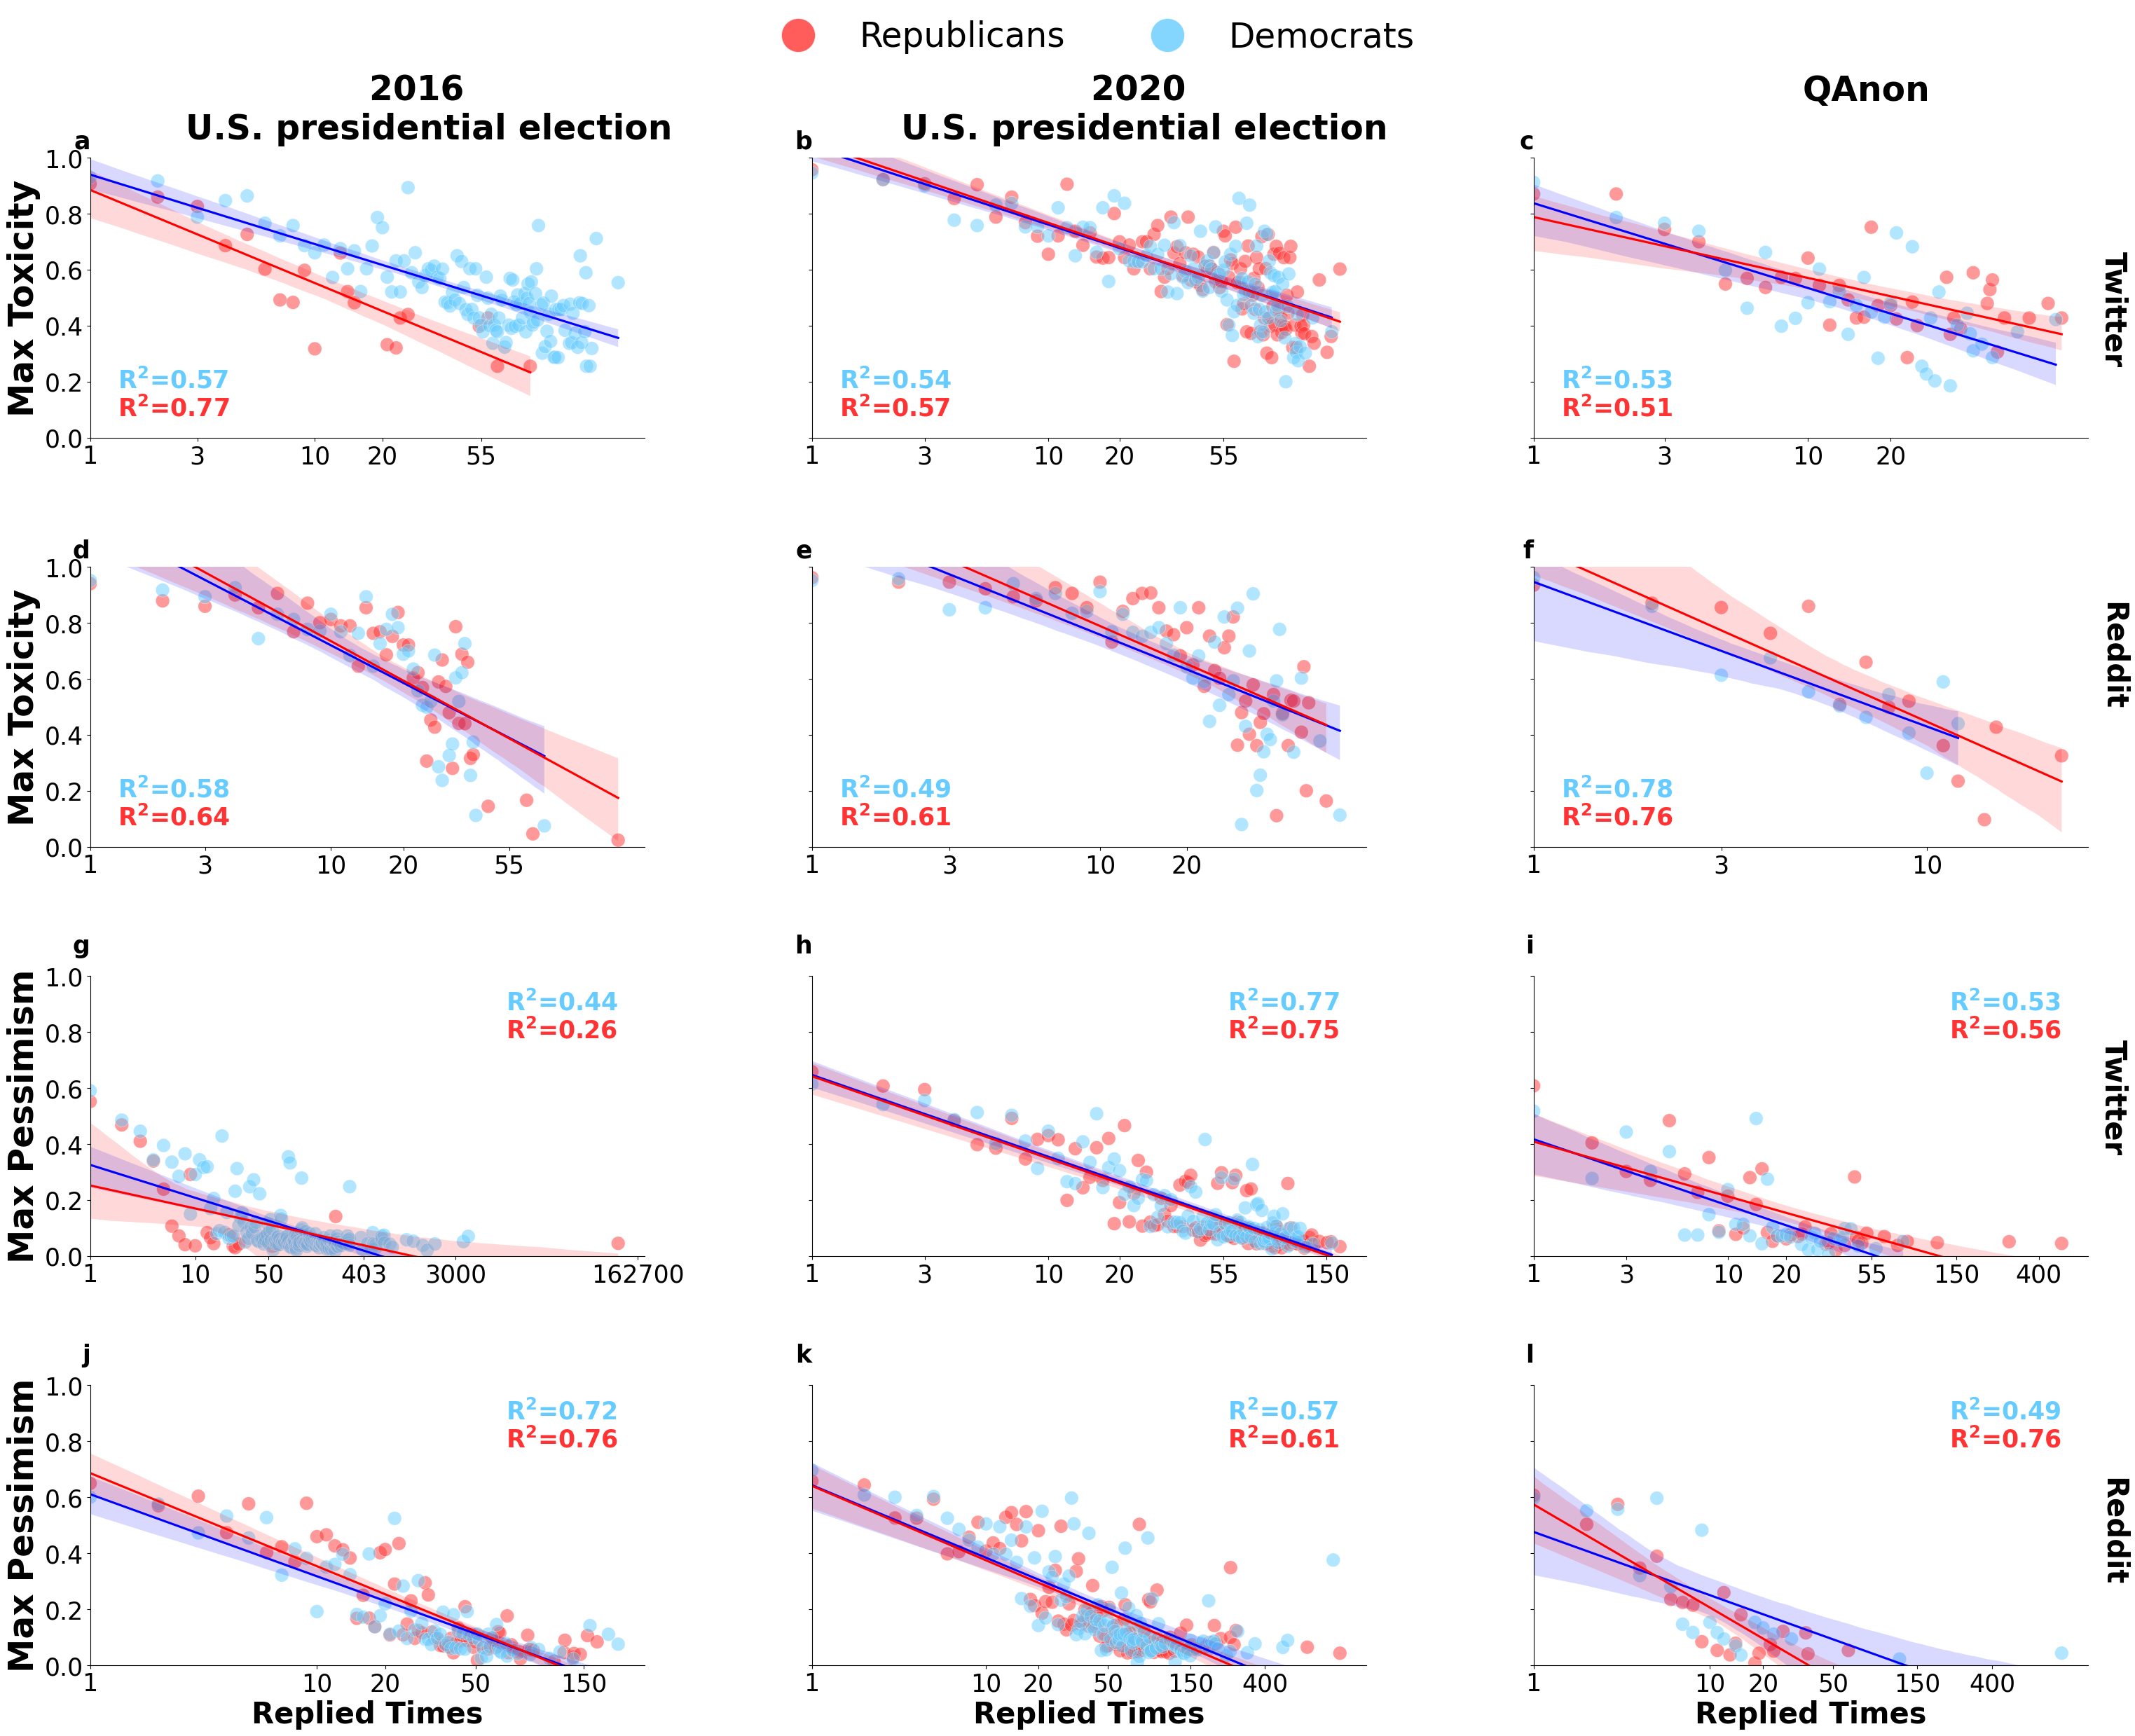

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# set legent colors(RGB)
colors = {'Democrats': (102/255, 204/255, 255/255, 0.8),  
          'Republicans': (255/255, 51/255, 51/255, 0.8)} 

# Manually create the handles in the legend and assign colors to each label
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Republicans', 
           markerfacecolor=colors['Republicans'], markersize=35),
    Line2D([0], [0], marker='o', color='w', label='Democrats', 
           markerfacecolor=colors['Democrats'], markersize=35)   
]
##FF3333 #66CCFF
party_colors = {'democrats': '#66CCFF', 'republicans': '#FF3333'} #{'democrats': '#A8CBDF', 'republicans': '#E79A90'}


fig, axes = plt.subplots(4, 3, figsize=(30, 25), sharey=True) 

datasets = [df_2016, df_2020, df_QAnon, df_Reddit_2016, df_Reddit_2020, df_Reddit_QAnon]
titles = ["2016 \n U.S. presidential election", "2020 \nU.S. presidential election", "QAnon", " ", " ", " "]

letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

# toxicity part
for i, df in enumerate(datasets):
    if i >= 6: 
        break
    ax = axes[i // 3, i % 3]  
    
    # scatter
    if i == 1:  
        scatter = sns.scatterplot(data=df, 
                                  x="log_count", 
                                  y="toxicity", 
                                  hue="party",
                                  palette=party_colors, 
                                  ax=ax, alpha=0.5,
                                  legend=False
                                  )
        
        legend = ax.legend(handles=legend_elements, loc='upper center', ncol=2,
                           frameon=False,
                           shadow=False, prop={'size': 35},
                           bbox_to_anchor=(0.5, 1.6))
    else:
        scatter = sns.scatterplot(data=df, 
                                  x="log_count", 
                                  y="toxicity", 
                                  sizes = 100,
                                  hue="party", alpha=0.5,
                                  palette=party_colors, 
                                  ax=ax,
                                   
                                  legend=False)
    
    for collection in scatter.collections:
        collection.set_sizes([200])  # dots size
    
    ax.text(0, 1.1, letters[i], transform=ax.transAxes, 
            fontsize=25, fontweight='bold', va='top', ha='right')
    
    df_democrats = df[df['party'] == 'democrats']
    df_republicans = df[df['party'] == 'republicans']
    df_democrats = df_democrats.dropna(subset = ['toxicity']) 
    df_republicans = df_republicans.dropna(subset = ['toxicity'])
    

    model_dem = LinearRegression()
    model_dem.fit(df_democrats[['log_count']], df_democrats['toxicity']) 
    predicted_dem = model_dem.predict(df_democrats[['log_count']])       # predictions values
    r2_dem = r2_score(df_democrats['toxicity'], predicted_dem)           # R^2
    

    correlation_dem = np.corrcoef(df_democrats['log_count'], df_democrats['toxicity'])[0, 1]
    sns.regplot(x=df_democrats['log_count'],
            y=df_democrats['toxicity'],
            order=1, ci=95,      
            scatter=False,     
            line_kws={"color": "blue"}, 
            ax=ax) #fr"$\mathbf{{R^2}}$={r2[index*2]}" #f"$R^2$={r2_dem:.2f}"
    ax.text(0.05, 0.25, fr"$\mathbf{{R^2}}$={r2_dem:.2f}", #R={correlation_dem:.2f}, 
        transform=ax.transAxes, fontsize=25, fontweight='bold', color='#66CCFF', va='top')
    
# Republicans regression analysis
    model_rep = LinearRegression()
    model_rep.fit(df_republicans[['log_count']], df_republicans['toxicity'])  
    predicted_rep = model_rep.predict(df_republicans[['log_count']])         
    r2_rep = r2_score(df_republicans['toxicity'], predicted_rep)            
    
#  r
    correlation_rep = np.corrcoef(df_republicans['log_count'], df_republicans['toxicity'])[0, 1]
    sns.regplot(x=df_republicans['log_count'],
            y=df_republicans['toxicity'],
            order=1, ci=95,      
            scatter=False,    
            line_kws={"color": "red"},  
            ax=ax)
    ax.text(0.05, 0.15,fr"$\mathbf{{R^2}}$={r2_rep:.2f}", #R={correlation_rep:.2f}
        transform=ax.transAxes,  fontsize=25, fontweight='bold', color='#FF3333', va='top')
    
    # set y axis range
    ax.set_ylim(0, 1)
    ax.set_xlim(0, )


    if i == 0:
        ticks = [1, 3, 10, 20, 55]
    elif i == 1:
        ticks = [1, 3, 10, 20, 55]  
    elif i == 2:
        ticks = [1, 3, 10, 20]
    
    elif i == 3:
        ticks = [1, 3, 10, 20, 55]
    elif i == 4:
        ticks = [1, 3, 10, 20]
    elif i == 5:
        ticks = [1, 3, 10]
    

    ax.set_xticks(np.log(ticks))
    ax.set_xticklabels([f"{tick}" for tick in ticks])

    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)

    #ax.set_title(f"{titles[i]}", fontweight='bold',fontsize= 25)
    #ax.title.set_position([0.5, 4])

    ax.text(0.6, 1.3, titles[i], transform=ax.transAxes, 
            fontsize=35, fontweight='bold', 
            va='top', ha='center')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 

    if i % 3 == 0:  
        ax.set_ylabel('Max Toxicity', fontsize=35, fontweight='bold')
    else:
        ax.set_ylabel('')

    if i // 3 == 1:  
        ax.set_xlabel('', fontsize=16)
    else:
        ax.set_xlabel('')


for i, df in enumerate(datasets):
    ax = axes[(i // 3) + 2, i % 3]  
    
    scatter = sns.scatterplot(data=df, 
                              x="log_count", 
                              y="pessimism", 
                              hue="party", alpha=0.5,
                              palette=party_colors, 
                              ax=ax, 
                              legend=False
                              )
    
    # scatter.collections
    for collection in scatter.collections:
        collection.set_sizes([200])  

    ax.text(0, 1.15, letters[i+6], transform=ax.transAxes, 
            fontsize=25, fontweight='bold', va='top', ha='right')
    
    df_democrats = df[df['party'] == 'democrats']
    df_republicans = df[df['party'] == 'republicans']
    df_democrats = df_democrats.dropna(subset = ['pessimism']) 
    df_republicans = df_republicans.dropna(subset = ['pessimism'])
    # Democrats 
    model_dem = LinearRegression()
    model_dem.fit(df_democrats[['log_count']], df_democrats['pessimism'])  
    predicted_dem = model_dem.predict(df_democrats[['log_count']])     
    r2_dem = r2_score(df_democrats['pessimism'], predicted_dem)           


    correlation_dem = np.corrcoef(df_democrats['log_count'], df_democrats['pessimism'])[0, 1]
    sns.regplot(x=df_democrats['log_count'],
            y=df_democrats['pessimism'],
            order=1, ci=95,      
            scatter=False,     
            line_kws={"color": "blue"}, 
            ax=ax)
    ax.text(0.75, 0.95,fr"$\mathbf{{R^2}}$={r2_dem:.2f}", #R={correlation_dem:.2f},
        transform=ax.transAxes,  fontsize=25, fontweight='bold', color='#66CCFF', va='top')

# Republicans 
    model_rep = LinearRegression()
    model_rep.fit(df_republicans[['log_count']], df_republicans['pessimism'])  
    predicted_rep = model_rep.predict(df_republicans[['log_count']])        
    r2_rep = r2_score(df_republicans['pessimism'], predicted_rep)             
    
    
# r
    correlation_rep = np.corrcoef(df_republicans['log_count'], df_republicans['pessimism'])[0, 1]
    sns.regplot(x=df_republicans['log_count'],
            y=df_republicans['pessimism'],
            order=1, ci=95,      
            scatter=False,    
            line_kws={"color": "red"},  
            ax=ax)
    ax.text(0.75, 0.85, fr"$\mathbf{{R^2}}$={r2_rep:.2f}", # R={correlation_rep:.2f},
        transform=ax.transAxes,  fontsize=25, fontweight='bold', color='#FF3333', va='top')
    
    ax.set_ylim(0, 1)
    ax.set_xlim(0, )

    # set x axis ticks
    
    if i == 0:
        ticks = [1, 10, 50, 403, 3000,162700]
    elif i == 1:
        ticks = [1, 3, 10, 20, 55, 150]  
    elif i == 2:
        ticks = [1, 3, 10, 20, 55, 150, 400]

    
    elif i == 3:
        ticks = [1, 10, 20, 50, 150]
    elif i == 4:
        ticks = [1, 10, 20, 50, 150, 400]
    elif i == 5:
        ticks = [1, 10, 20, 50, 150, 400]
    
    ax.set_xticks(np.log(ticks))
    ax.set_xticklabels([f"{tick}" for tick in ticks])
    
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 

    if i % 3 == 0:
        ax.set_ylabel('Max Pessimism', fontsize=35, fontweight='bold')
    else:
        ax.set_ylabel('')

    if i // 3 == 1:  
        ax.set_xlabel('Replied Times', fontsize=30, fontweight='bold')
    else:
        ax.set_xlabel('')


#fig.text(-0.02, 0.75, 'Toxicity Max', fontweight='normal', va='center', rotation='vertical', fontsize=30)
#fig.text(-0.02, 0.3, 'Pessimism Max', fontweight='normal', va='center', rotation='vertical', fontsize=30)

fig.text(1, 0.85, 'Twitter', fontweight='bold',va='top',rotation=-90, fontsize=30, ha='left')
fig.text(1, 0.65, 'Reddit',fontweight='bold', va='top', rotation=-90,fontsize=30, ha='left')
fig.text(1, 0.4, 'Twitter', fontweight='bold',va='top', rotation=-90,fontsize=30, ha='left')
fig.text(1, 0.15, 'Reddit',fontweight='bold', va='top', rotation=-90, fontsize=30, ha='left')


plt.tight_layout()
plt.savefig("pic/Reply_pessimisn_and_toxicity[2platforms]_v8.png",dpi=300, bbox_inches='tight') 
plt.show()


## 4.2 Fitted equation

### Toxicity Max

In [ ]:
import numpy as np
# Toxicity
datasets = [df_2016, df_2020, df_QAnon, df_Reddit_2016, df_Reddit_2020, df_Reddit_QAnon]
titles = ["Twitter2016", "Twitter2020", "TwitterQAnon", "Reddit2016", "Reddit2020", "RedditQAnon"]

results = []
for i, df in enumerate(datasets):
    if i >= 6: 
        break

    df_democrats = df[df['party'] == 'democrats']
    df_republicans = df[df['party'] == 'republicans']
    df_democrats = df_democrats.dropna(subset = ['toxicity']) 
    df_republicans = df_republicans.dropna(subset = ['toxicity'])
    
    # Republicans
    coefficients_republicans = np.polyfit(df_republicans['log_count'], df_republicans['toxicity'], 1)
    a_r, b_r = coefficients_republicans  
    equation_republicans = f"y = {a_r:.2f}x + {b_r:.2f}"

# Democrats
    coefficients_democrats = np.polyfit(df_democrats['log_count'], df_democrats['toxicity'], 1)
    a_d, b_d = coefficients_democrats  
    equation_democrats = f"y = {a_d:.2f}x + {b_d:.2f}"
    
 
    #vertex_republicans = -b_r / (2 * a_r)
    #vertex_democrats = -b_d / (2 * a_d)

    # Republicans 
    print(f"{titles[i]} - Republicans: 拟合的方程为: y = {equation_republicans}")
    #print(f"{titles[i]} - Republicans: 极值点 x = {vertex_republicans:.3f}")

    # Democrats 
    print(f"{titles[i]} - Democrats: 拟合的方程为: y = {equation_democrats}")
    #print(f"{titles[i]} - Democrats: 极值点 x = {vertex_democrats:.3f}")


    results.append({
        "Dataset": titles[i],
        "Rep_a": a_r, "Rep_b": b_r,
        "Dem_a": a_d, "Dem_b": b_d,
    })

df_results = pd.DataFrame(results)

Twitter2016 - Republicans: 拟合的方程为: y = y = -0.14x + 0.88
Twitter2016 - Democrats: 拟合的方程为: y = y = -0.11x + 0.94
Twitter2020 - Republicans: 拟合的方程为: y = y = -0.12x + 1.05
Twitter2020 - Democrats: 拟合的方程为: y = y = -0.12x + 1.04
TwitterQAnon - Republicans: 拟合的方程为: y = y = -0.09x + 0.79
TwitterQAnon - Democrats: 拟合的方程为: y = y = -0.13x + 0.84
Reddit2016 - Republicans: 拟合的方程为: y = y = -0.20x + 1.20
Reddit2016 - Democrats: 拟合的方程为: y = y = -0.19x + 1.17
Reddit2020 - Republicans: 拟合的方程为: y = y = -0.20x + 1.24
Reddit2020 - Democrats: 拟合的方程为: y = y = -0.18x + 1.17
RedditQAnon - Republicans: 拟合的方程为: y = y = -0.27x + 1.07
RedditQAnon - Democrats: 拟合的方程为: y = y = -0.22x + 0.95


In [6]:
df_results

,Dataset,Rep_a,Rep_b,Dem_a,Dem_b
0,Twitter2016,-0.144387,0.884155,-0.107739,0.938872
1,Twitter2020,-0.124299,1.052872,-0.120247,1.037190
2,TwitterQAnon,-0.094379,0.787216,-0.131591,0.836775
3,Reddit2016,-0.203842,1.203569,-0.193758,1.165284
4,Reddit2020,-0.195275,1.237606,-0.179053,1.169428
5,RedditQAnon,-0.270818,1.069973,-0.224287,0.945548


### Pessimism Max

In [8]:
df_results

,Dataset,Rep_a,Rep_b,Dem_a,Dem_b
0,Twitter2016,-0.035662,0.251488,-0.051088,0.325012
1,Twitter2020,-0.127456,0.641559,-0.126872,0.646166
2,TwitterQAnon,-0.084934,0.408010,-0.102598,0.416392
3,Reddit2016,-0.144434,0.685461,-0.127272,0.610051
4,Reddit2020,-0.115527,0.639954,-0.112504,0.642160
5,RedditQAnon,-0.159860,0.573474,-0.098074,0.475307


### users count

In [ ]:

count_results = []

for i, df in enumerate(datasets):

    df_democrats = df[df['party'] == 'democrats']
    df_republicans = df[df['party'] == 'republicans']

    len_democrats = len(df_democrats)
    len_republicans = len(df_republicans)

    print(f"{titles[i]} - Democrats count: {len_democrats}, Republicans count: {len_republicans}")

    count_results.append({
        "Dataset": titles[i],
        "Democrats_Count": len_democrats,
        "Republicans_Count": len_republicans
    })

df2 = pd.DataFrame(count_results)


Twitter2016 - Democrats count: 175, Republicans count: 23
Twitter2020 - Democrats count: 299, Republicans count: 327
TwitterQAnon - Democrats count: 36, Republicans count: 39


## 4.3 violin plot

In [6]:
import os
folder_path = "data4datavisualization/data4boxplot"

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if file_name.endswith(".csv"):
        dataset_name = os.path.splitext(file_name)[0]
        globals()[dataset_name] = pd.read_csv(file_path)
        print(f"Loaded: {file_name}, Shape: {globals()[dataset_name].shape}")


Loaded: boxplotRedditQAnon.csv, Shape: (2710, 17)
Loaded: boxplotTwitter2020.csv, Shape: (29490, 20)
Loaded: boxplotReddit2016.csv, Shape: (16951, 17)
Loaded: boxplotTwitter2016.csv, Shape: (9524, 21)
Loaded: boxplotTwitterQAnon.csv, Shape: (183006, 17)
Loaded: boxplotReddit2020.csv, Shape: (34902, 17)


In [7]:
boxplotRedditQAnon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           2710 non-null   object 
 1   text                     2710 non-null   object 
 2   perspective_api_results  2668 non-null   object 
 3   toxicity_score           2668 non-null   float64
 4   anger                    2710 non-null   float64
 5   anticipation             2710 non-null   float64
 6   disgust                  2710 non-null   float64
 7   fear                     2710 non-null   float64
 8   joy                      2710 non-null   float64
 9   love                     2710 non-null   float64
 10  optimism                 2710 non-null   float64
 11  pessimism                2710 non-null   float64
 12  sadness                  2710 non-null   float64
 13  surprise                 2710 non-null   float64
 14  trust                   

In [8]:
df_list = [boxplotTwitter2016, boxplotTwitter2020, boxplotTwitterQAnon, boxplotReddit2016, boxplotReddit2020 ,boxplotRedditQAnon]

In [18]:
boxplotRedditQAnon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2710 entries, 0 to 2709
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   replied author           2710 non-null   object 
 1   text                     2710 non-null   object 
 2   perspective_api_results  2668 non-null   object 
 3   toxicity_score           2668 non-null   float64
 4   anger                    2710 non-null   float64
 5   anticipation             2710 non-null   float64
 6   disgust                  2710 non-null   float64
 7   fear                     2710 non-null   float64
 8   joy                      2710 non-null   float64
 9   love                     2710 non-null   float64
 10  optimism                 2710 non-null   float64
 11  pessimism                2710 non-null   float64
 12  sadness                  2710 non-null   float64
 13  surprise                 2710 non-null   float64
 14  trust                   

In [19]:
boxplotRedditQAnon

replied author  \
0              -Merlin-   
1      -_Quetzalcoatl_-   
2       2020clusterfuck   
3          2Big_Patriot   
4     2_Spicy_2_Impeach   
...                 ...   
2705  undetachablepenis   
2706        wolfman4807   
2707             y2jeff   
2708          ymeskhout   
2709            zed1207   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

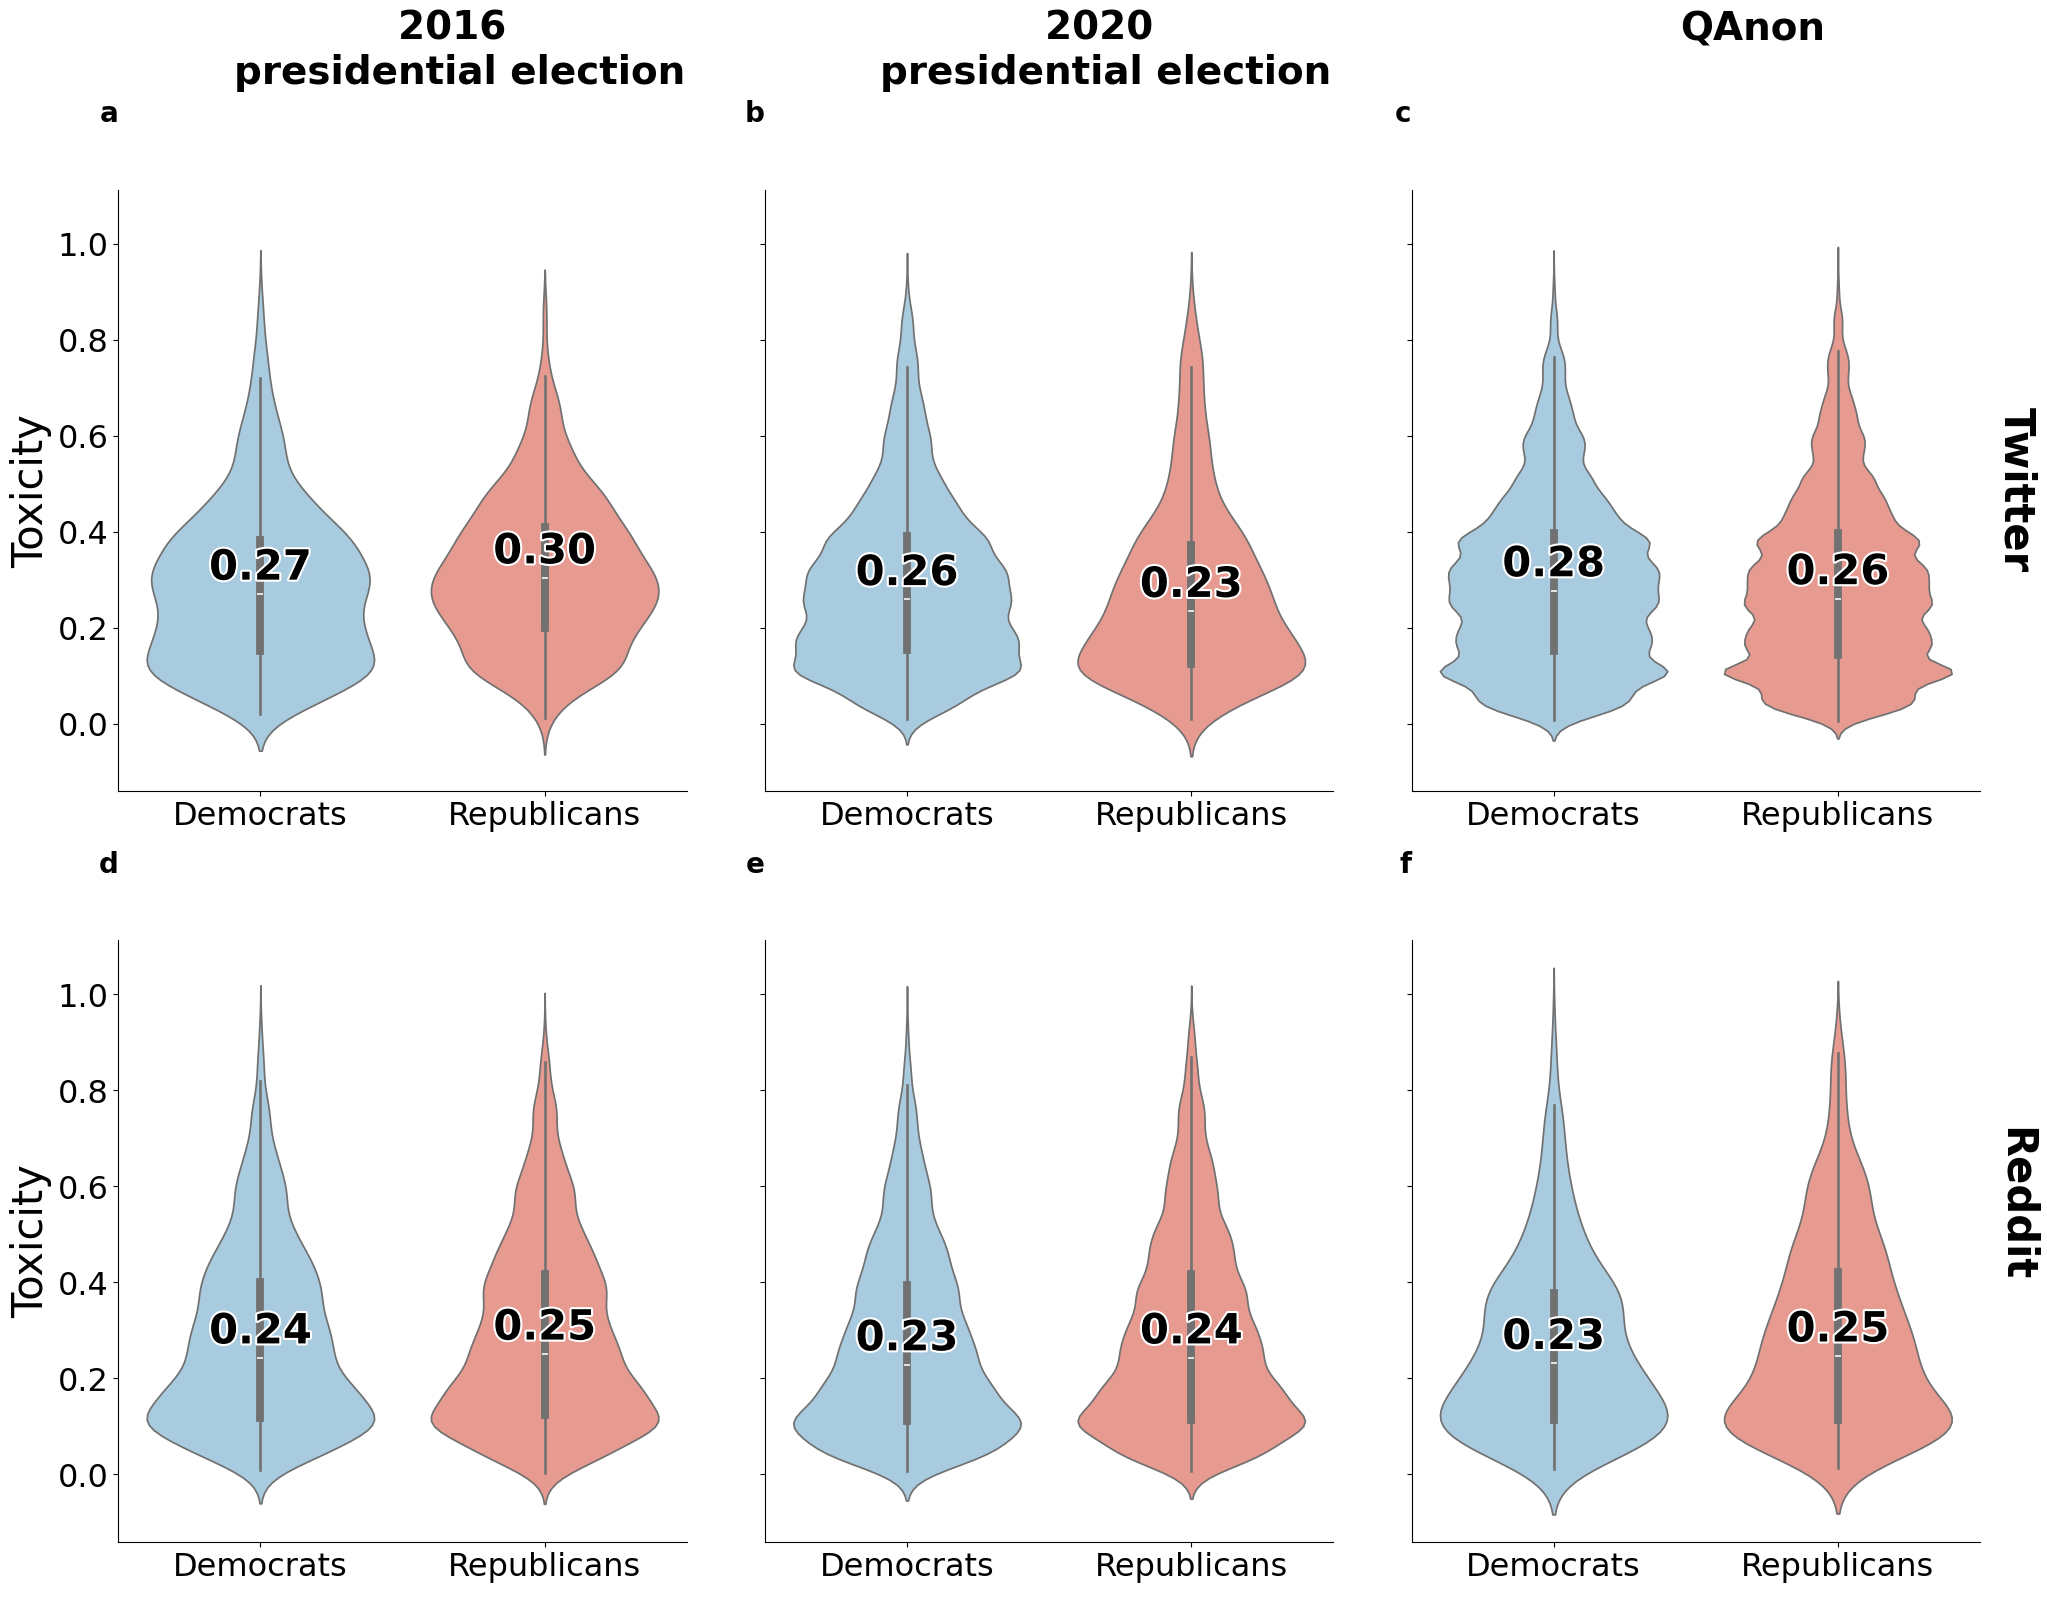

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patheffects import withStroke

# legend color
colors = {'Democrats': (168/255, 203/255, 223/255, 0.5),  
          'Republicans': (231/255, 154/255, 144/255, 0.5)}  

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Republicans', 
           markerfacecolor=colors['Republicans'], markersize=35),
    Line2D([0], [0], marker='o', color='w', label='Democrats', 
           markerfacecolor=colors['Democrats'], markersize=35)   
]

party_colors = {'Democrats': '#A8CBDF', 'Republicans': '#E79A90'}

fig, axes = plt.subplots(2, 3, figsize=(20, 16), sharey=True) 
axes = axes.flatten()
titles = ["2016 \npresidential election", "2020 \npresidential election", "QAnon", "", "", ""]
letters = ['a', 'b', 'c', 'd', 'e', 'f'] #, 'g', 'h', 'i', 'j', 'k', 'l']

offset = 0.03
for i, df in enumerate(df_list):
    ax = axes[i]                         
    # violin plot
    sns.violinplot(y="toxicity", x="party", palette=party_colors, data=df, ax=ax, saturation=1,order=['Democrats','Republicans'])
    
    # meidan value annotation
    for category in ["Democrats", "Republicans"]:
        median_y = df[df["party"] == category]["toxicity"].median()  
        x_center = ["Democrats", "Republicans"].index(category) 
        ax.text(x_center, median_y+0.03, f"{median_y:.2f}", color="black", 
                ha="center", fontweight='bold', fontsize=30,
                path_effects=[withStroke(linewidth=3, foreground="white")])
        
    # add annotations
    ax.text(0, 1.15, letters[i], transform=ax.transAxes, 
            fontsize=20, fontweight='bold', va='top', ha='right')
    
    # adjust ticks size
    ax.tick_params(axis='x', labelsize=23)
    ax.tick_params(axis='y', labelsize=23)
    ax.text(0.6, 1.3, titles[i], transform=ax.transAxes, 
            fontsize=28, fontweight='bold', 
            va='top', ha='center')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Toxicity", fontsize=30)
    ax.set_xlabel(' ', fontsize=2) 
fig.text(1, 0.75, 'Twitter',fontweight='bold',va='top', rotation=-90, fontsize=30, ha='left')
fig.text(1, 0.3, 'Reddit', fontweight='bold', va='top', rotation=-90, fontsize=30, ha='left')

# adjust
plt.tight_layout()
plt.savefig("pic/Violinplot_Replied_toxicity.png",dpi=300, bbox_inches='tight')
plt.show()